In [158]:
# -*- coding=utf-8 -*-
# __author = 'bonnieting'__

# basic:
import pandas as pd
pd.set_option('display.float_format',lambda x:'%.2f' %x)
# pd.set_option('display.float_format', '{:.0f}'.format)
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import jieba
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
from itertools import product
import warnings
warnings.filterwarnings('ignore')
# time:
from datetime import datetime as dt
import time

# visual:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import plotly.express as px
from plotly import graph_objects as go
import plotly.figure_factory as ff
# import plotly.offline as pltol
# init_notebook_mode(connected=True)
import plotly as ply
ply.offline.init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import seaborn as sns
sns.set(style="whitegrid")

from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
from pyecharts import options as opts
from pyecharts.charts import Bar

# model:
from scipy.stats import norm
from pyecharts import options as opts
from scipy.stats.mstats import winsorize

# dataframe show_way:
from IPython.display import Markdown, display, HTML
# from IPython.display import display
# import os
# import sys
# sys.path.insert(0, '../common')
# from common_htmlTable import HtmlTableMulti
# from IPython.display import display, display_html

In [159]:
data=pd.read_csv(r"D:\repo_github\Portfolio\Portfolio1_sales_EDA\data\2019-Dec.csv")

# **Preliminery EDA**
***

## Data Overview

In [162]:
data.head()

event_time        event_type  product_id          category_id  \
0  2019-12-01 00:00:00 UTC  remove_from_cart     5712790  1487580005268456287   
1  2019-12-01 00:00:00 UTC              view     5764655  1487580005411062629   
2  2019-12-01 00:00:02 UTC              cart        4958  1487580009471148064   
3  2019-12-01 00:00:05 UTC              view     5848413  1487580007675986893   
4  2019-12-01 00:00:07 UTC              view     5824148  1487580005511725929   

  category_code      brand  price    user_id  \
0           NaN      f.o.x   6.27  576802932   
1           NaN        cnd  29.05  412120092   
2           NaN     runail   1.19  494077766   
3           NaN  freedecor   0.79  348405118   
4           NaN        NaN   5.56  576005683   

                           user_session  
0  51d85cb0-897f-48d2-918b-ad63965c12dc  
1  8adff31e-2051-4894-9758-224bfa8aec18  
2  c99a50e8-2fac-4c4d-89ec-41c05f114554  
3  722ffea5-73c0-4924-8e8f-371ff8031af4  
4  28172809-7e4a-45ce-bab0-5efa90117cd5

In [163]:
print(data.shape)
print(data.info())

(3533286, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3533286 entries, 0 to 3533285
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 242.6+ MB
None


In [164]:
data.isnull().any()

event_time       False
event_type       False
product_id       False
category_id      False
category_code     True
brand             True
price            False
user_id          False
user_session      True
dtype: bool

In [165]:
data.nunique()

event_time       1654771
event_type             4
product_id         44624
category_id          482
category_code         10
brand                252
price               2122
user_id           370154
user_session      839812
dtype: int64

>- [ ] need to see the null in detail
>- [ ] build a scatterplot to see the time distribution of different behaviors.

## Global metrics

### total_uv & total_pv
_uv: unique visitor ; pv: page view; in total not in each 24hrs_

In [169]:
event_frequency = data['user_id'].value_counts()
print('event_frequency: \n' + str(event_frequency))
total_uv = len(event_frequency)
print('\ntotal_uv: '+str(total_uv))
total_pv = len(data['user_id'])
print('\ntotal_pv: '+str(total_pv))

event_frequency: 
user_id
527021202    8689
572631412    3883
467810091    3147
548810441    2426
584289031    2356
             ... 
561547151       1
586485554       1
586486068       1
363648439       1
595414541       1
Name: count, Length: 370154, dtype: int64

total_uv: 370154

total_pv: 3533286


### total_order
_total closing orders volume 总成交量_

In [171]:
total_order = len(data[data.event_type=='purchase']['user_session'].value_counts())
print('total_order: '+str(total_order))
#delete invalid column 删除无效列
# data.drop('category_code',axis=1,inplace=True)

total_order: 28894


### GMV
_gross merchandise volume(ignoring the returns and refunds) 总成交额/gmv（不考虑退货退款）_

In [173]:
total_gmv = data[data.event_type=='purchase']['price'].sum()
print('total_gmv: '+str(locale.currency(total_gmv,grouping = True))) # f'{total_gmv:.2f}'

total_gmv: $1,077,624.85


In [174]:
paid_user = data[data.event_type=='purchase'].nunique()['user_id']
Average_Purchase_Amount = total_gmv/paid_user
print('Average Purchase Amount (mean_amt_per_paid_user): ' + str(locale.currency(Average_Purchase_Amount,grouping = True)))

Average Purchase Amount (mean_amt_per_paid_user): $42.07


### price

In [176]:
data['price'].describe()

count   3533286.00
mean          8.87
std          19.86
min         -79.37
25%           2.06
50%           4.21
75%           7.14
max         327.78
Name: price, dtype: float64

> - [x] __need to clear the price <0__

### event type
_categorical statistics on purchase behavior 购买行为分类统计_

In [179]:
user_event_count = data['event_type'].value_counts()
print(user_event_count)

event_type
view                1728331
cart                 927124
remove_from_cart     664655
purchase             213176
Name: count, dtype: int64


> - [x] funnel model
> - [ ] how many views does a customer purchase after that in average?
> - [ ] how many views does a customer purchase the same one product after that in average?

## Rawdata Cleaning

In [182]:
data[['user_id','product_id','category_id','user_session']] = data[['user_id','product_id','category_id','user_session']].astype(str)
data.describe()

price
count 3533286.00
mean        8.87
std        19.86
min       -79.37
25%         2.06
50%         4.21
75%         7.14
max       327.78

In [183]:
data[data['price']<0]['product_id'].value_counts()

product_id
5670257    8
5716859    4
5716857    2
5716855    2
5716861    2
Name: count, dtype: int64

> should be the problem of these products. I need to see details by SQL from the product_table in database.
>
> put them into 0 for now.

In [185]:
# data['price'] = data['price'].where(data['price']<0, inplace=True)
data['price'] = data['price'].apply(lambda x: max(0, x))
data[data['price']<0]

Empty DataFrame
Columns: [event_time, event_type, product_id, category_id, category_code, brand, price, user_id, user_session]
Index: []

In [186]:
data[(data['price']==0) & (data['event_type']=='purchase')]['category_id'].value_counts() # ['event_type'].value_counts()

category_id
1487580014042939619    18
Name: count, dtype: int64

> some price of view/cart/remove_from_cart type were set as 0 which meant 0 was normal.
> 
> the 18 records of free purchase had the same category_id and different product_id which may be free trial or something.

In [188]:
# data[data['brand'].isnull()]
# there're 1510289 rows with no brand info

In [189]:
data[['category_code','brand','user_session']] = data[['category_code','brand','user_session']].fillna('null')
data.isnull().any()
# data[data['brand']=='null']

event_time       False
event_type       False
product_id       False
category_id      False
category_code    False
brand            False
price            False
user_id          False
user_session     False
dtype: bool

# **CUSTOMER ANALYSIS**
_by user_id_
***

## Key Point Indicators KPI 

### gross conversion rate 转化率
* *closign ratio 成交率 = unique_paid_user/total_uv*
* *total_paid_rate: What percentage of people who buy, among all the people who browse, add, and buy*

In [193]:
view_user = data[data.event_type=='view'].nunique()['user_id']
print('view_user: '+str(view_user))
total_view_rate = (view_user/total_uv)*100
print('total_view_rate: '+str('%.2f'%total_view_rate)+'%')

cart_user = data[data.event_type=='cart'].nunique()['user_id']
print('\ncart_user: '+str(cart_user))
total_cart_rate = (cart_user/total_uv)*100
print('total_cart_rate: '+str('%.2f'%total_cart_rate)+'%')
cart_pct_inview = (cart_user/view_user)*100
print('cart_pct_inview: '+str('%.2f'%cart_pct_inview)+'%')

# pre-defined: paid_user = data[data.event_type=='purchase'].nunique()['user_id']
print('\npaid_user: '+str(paid_user)) # '%.0f'%
total_paid_rate = (paid_user/total_uv)*100
print('total_paid_rate: '+str('%.2f'%total_paid_rate)+'%')
paid_pct_incart = (paid_user/cart_user)*100
print('paid_pct_incart: '+str('%.2f'%paid_pct_incart)+'%')
paid_pct_inview = (paid_user/view_user)*100
print('paid_pct_inview: '+str('%.2f'%paid_pct_inview)+'%')

view_user: 358212
total_view_rate: 96.77%

cart_user: 83458
total_cart_rate: 22.55%
cart_pct_inview: 23.30%

paid_user: 25613
total_paid_rate: 6.92%
paid_pct_incart: 30.69%
paid_pct_inview: 7.15%


> - User behavior flow path:
> 1. view->cart->purchase
> 2. view->purchase
> 3. open app->purchase directly
> 
> - [ ] group by user_id, product_id, in/ not in one user_session
> - [ ] how long does a customer cost in each link in one user session? -> need more data 

#### funnelplot

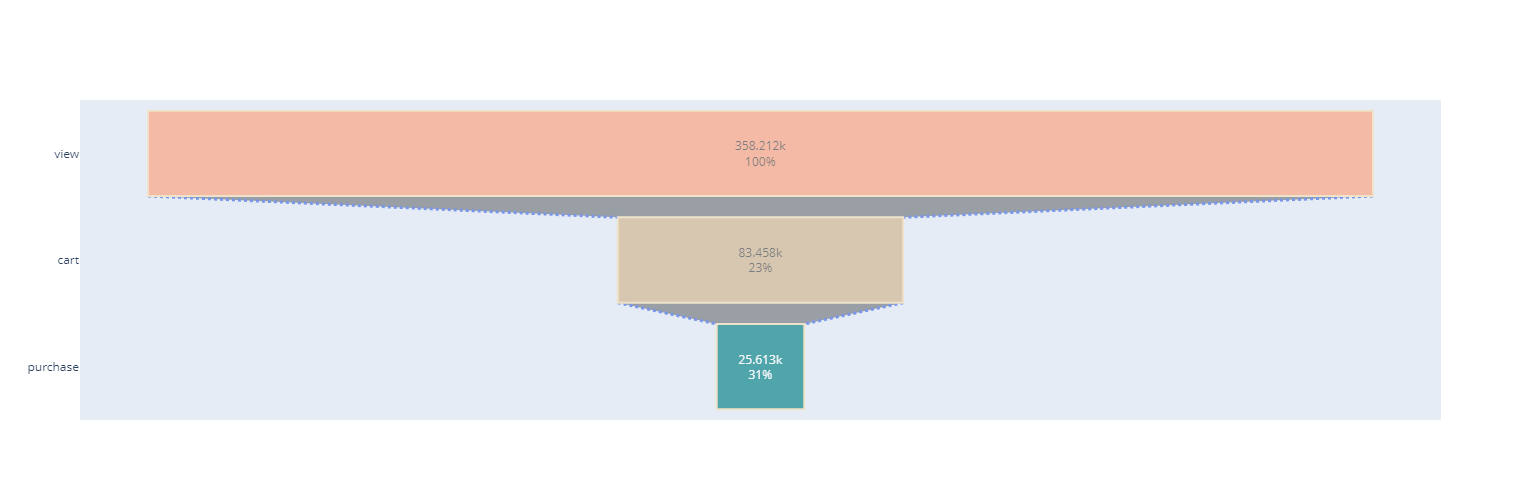

In [196]:
fig = go.Figure(go.Funnel(
    y = ["view", "cart", "purchase"],
    x = [view_user, cart_user, paid_user],
    textposition = "inside",
    textinfo = "value + percent previous",
    opacity = 0.65, marker = {"color": ["lightsalmon", "tan", "teal"],
    "line": {"width": [2, 2, 2], "color": ["wheat", "wheat", "wheat",]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )
fig.update_layout(width=1000, height=500)
fig.show()

#### CVR insights
- [ ] need a reference object to decide if the flow percentages are lower than normal ones.(Maybe data from competitive products or the benchmark of a specific field.) -> need more data
- [ ] Nevertheless, only 23% from view to cart is not enough. I think usually the first thing is to check if there are tremendous diffs between brands which means the product media materials(pics or vedios) matter a lot if yes.
    - One Step Forward, we can do simple ABTest on materials with Product Department to verify the hypothesis.
    - Two step forward, we need Marketing Department to do more optimizing the overall quality of materials. For example,
        - Give good examples of materials
        - Regularly update with a series of training courses that teach brand stores how to optimize materials well
        - Emphasize the importance of materials when merchants enter the platform
        - Or even develop a new backend feature that automatically generates and beautifies materials
- if it's not materials, it could be:
    - recommender system needs optimizing: products dont meet their needs.
    - unfriendly interface: the confusing function button in the converting page
    - the unreasonable price: like higher than competition
    - the website experience issues: like loading slowly or a complicated process or unstable connection

### purchase frequency 用户购买频率
_Distribution of buying times per user 用户购买次数分布_

In [199]:
user_buy_times = data[data.event_type=='purchase'].groupby('user_id').count()['user_session'] 
# output Series，should we calculate the frequency in the all "purchase" users or in the all? I think the former making sense.
user_buy_times

user_id
101025416    11
103274988    17
105075440     2
105118203     8
105379623     6
             ..
98079173     14
99011711      4
99293243      7
99499363      8
99666343      1
Name: user_session, Length: 25613, dtype: int64

In [200]:
user_buy_times.describe()

count   25613.00
mean        8.32
std        10.74
min         1.00
25%         3.00
50%         5.00
75%        10.00
max       399.00
Name: user_session, dtype: float64

In [201]:
print('max_buying_times: ' + str(user_buy_times.max()))
print('min_buying_times: ' + str(user_buy_times.min()))
Average_Purchase_Frequency = user_buy_times.mean()
print('Average Purchase Frequency (mean_buying_times_per_paid_user): ' + str('%.2f'%Average_Purchase_Frequency))
# buy_times_over20 = user_buy_times.values > 20
# buy_times_over20 = np.count_nonzero(buy_times_over20)
# buy_times_over20 = np.sum(buy_times_over20)
# buy_times_over20

max_buying_times: 399
min_buying_times: 1
Average Purchase Frequency (mean_buying_times_per_paid_user): 8.32


In [202]:
buy_times_within_20 = len(user_buy_times[(user_buy_times >= 0) & (user_buy_times <= 20)])
print('Buying_times between [0-20]: ' + str(buy_times_within_20))
buy_times_within_20_ratio = (buy_times_within_20 / paid_user)*100
print("Buying_times between [0-20] ratio: ", str('%.2f'%buy_times_within_20_ratio)+'%')

Buying_times between [0-20]: 23701
Buying_times between [0-20] ratio:  92.54%


#### frequency distribution histplot
_to see how many users bought how many times 有多少用户买了XX次_

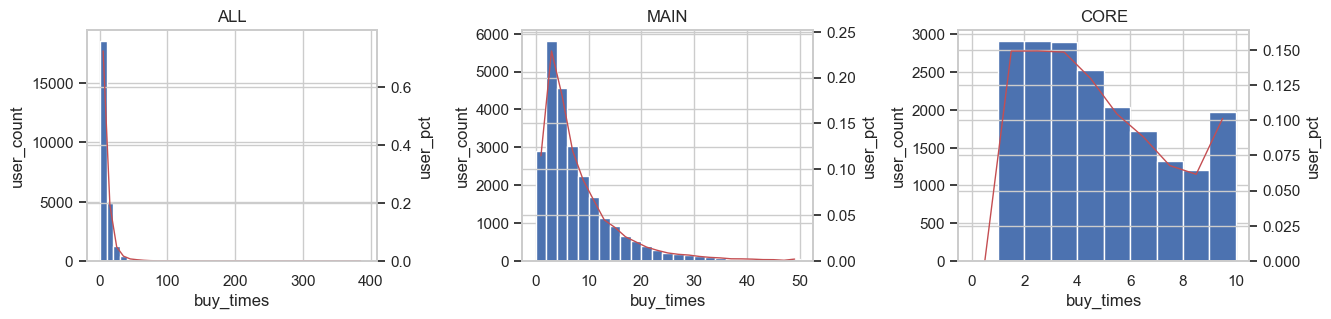

In [204]:
def plot_histogram(ax, data, title, bins):
    n, bins, patches = ax.hist(x=data, bins=bins, density=False)
    ax.set_xlabel('buy_times')
    ax.set_ylabel('user_count')

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    freq = n / n.sum()

    ax2 = ax.twinx()
    ax2.plot(bin_centers, freq, 'r-', linewidth=1.0)
    ax2.set_ylabel('user_pct')
    ax2.set_ylim([0, freq.max() * 1.1])
    ax.set_title(title)

    return ax, ax2, n, freq

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
plt.subplots_adjust(wspace=0.5)

plot_histogram(axes[0], user_buy_times, 'ALL', np.arange(0, 400, 10))
plot_histogram(axes[1], user_buy_times[user_buy_times.values<51], 'MAIN', np.arange(0, 51, 2))
plot_histogram(axes[2], user_buy_times[user_buy_times.values<11], 'CORE', np.arange(0, 11, 1))

plt.show()

In [205]:
# print('times data was split into ' + str(len(n)) + ' groups by steplength: 10 .')
# freq = freq.tolist()
# freq = [f'{f*100:.2f}'+'%' for f in freq]
# df1 = pd.DataFrame({'Buying_times From': bins[:-1], 'Buying_times To': bins[1:], 'Frequency': n, 'Normalized Frequency': freq})
# df1.head(13)

> - [ ] can build the VIP system or Key Customers list from the buying_times & buying_amount

### repurchase rate 用户复购率 
_number of users who bought more than once 复购率（购买次数在2次及以上的人数/有过购买记录的人数）_

In [208]:
twice_buy_user=user_buy_times[user_buy_times>=2].count()
twice_buy_user
rebuy_rate=(twice_buy_user/paid_user)*100
print('rebuy_rate: '+str('%.2f'%rebuy_rate)+'%')
# print("复购率:{:.2f}%".format(rebuy_rate*100))

rebuy_rate: 88.64%


#### rebuy insights
- rebuy_rate: 88.64% even though 75% user never bought more than 10 times, which means the customer loyalty of this platform is nearly perfect. (I will set "raising rebuy_times of all rebuy customers" aside from "raising rebuy_rate of all paid customers" which are two different things.)
- So the point will be "let customers choose us once."(dont need to be the first exposure just need one chance to make a try--> "free trial on deliver-cost or cosmetics samples for women" would be nice to move forward). Besides, the point will be:
    - on the Marketing Deparment to gain trust in the exposures by compelling pictures or videos,
    - or on the PM Team to design a function to showcase rates, comments, star-level of brands/products,
    - or on the Referral Algorithm Team to optimize the contents in cover-feed and search results.
- [ ] how long does a customer cost to rebuy after the first bought in average (to further determine the health) ?
- [ ] how long between two buying actions of one user in average ?

### churn cate 用户流失率
_rate of customers who gave up using or buying on our platform 放弃使用、不再活跃的用户比率 reduce churn rate to retain more customers._

- unique users only view / total_uv
- unique users only cart (not to purchase / total_uv
- unique users only buy once / total_uv

In [211]:
# we have variable: event_frequency = data['user_id'].value_counts() = data.groupby('user_id').count()['user_session']
once_buy_user = user_buy_times[user_buy_times==1].count()
once_buy_rate = (once_buy_user/total_uv)*100
print('once_buy_churn_rate: '+str('%.2f'%once_buy_rate)+'%')

once_buy_churn_rate: 0.79%


In [212]:
event_type_df = data.groupby(['user_id', 'event_type']).count().reset_index()
df3 = event_type_df[event_type_df['event_type']=='view']['user_id']
user_event_type_nums = event_type_df.groupby('user_id').count()['user_session']
user_event_type_nums
only_view_user = len(set(user_event_type_nums[user_event_type_nums==1].index).intersection(set(df3.values)))
only_view_rate = (only_view_user/total_uv)*100
print('only_view_churn_rate: '+str('%.2f'%only_view_rate)+'%')

only_view_churn_rate: 76.80%


In [213]:
df5 = event_type_df[event_type_df['event_type']=='cart']['user_id']
cart_no_buy = len(set(df5.values).difference(set(user_buy_times.index)))
cart_no_buy_rate = (cart_no_buy/len(df5))*100
print(str(cart_no_buy) + ' persons in 83458 cart customers didn\'t go to purchase. The only_cart churn rate for the very cart link is: ' + str('%.2f'%cart_no_buy_rate) + '%.')

cart_no_buy_rate_intotal = (cart_no_buy/total_uv)*100
print('only_cart_churn_rate: ' +str('%.2f'%cart_no_buy_rate_intotal) + '%.')

58168 persons in 83458 cart customers didn't go to purchase. The only_cart churn rate for the very cart link is: 69.70%.
only_cart_churn_rate: 15.71%.


In [214]:
cart_from_view = len(set(set(df5.values).intersection(set(df3.values))))
cart_from_view_rate = (cart_from_view/len(df5))*100
print(str(cart_from_view) + ' persons in 83458 cart customers came from view. The rate is: ' + str('%.2f'%cart_from_view_rate) + '%.')

72359 persons in 83458 cart customers came from view. The rate is: 86.70%.


In [215]:
print('The total churn rate is: ' + str('%.2f'%sum([once_buy_rate, cart_no_buy_rate_intotal, only_view_rate])) + '%.')

The total churn rate is: 93.30%.


#### churn rate insights
- which means the churn rate of **cart_without_buy** and **only_view**  is not low even though the repurchase rate is highly to 88.64%. So we team should focus on **how to let people try just once**. For reference:
    - increasing the conversion rate in user flow to enhance the purchase on the end
    - holding offer campaigns to drawing people to order for the first time
    - guiding customers to make decision: like providing "compare"/"rating" function or lightening the crucial comments
    - collecting feedback and making improvements

(similiar conclusions to the rebuy insights)
- cart_without_buy includes customers who view to cart and just cart directly.
**the part in view customers went to purchase is 30.3% from "The only_cart_churn_rate is: 69.70%", less than paid_pct_incart=30.69% in conversion rate chapter by 0.387% because 323 customers purchased directly after view without add to cart, which also means 98.74% of purchase came from cart, a essential function.**

## Customer Lifetime Value LTV 用户生命周期价值
_Refined operation of users_

### total LTV
_total_LTV = Average Customer Lifespan * Average Purchase Frequency * Average Purchase Amount_

In [219]:
event_time_df = data[data.event_type=='purchase'].groupby('user_id')['event_time'].agg(['min', 'max', 'count']).rename(columns={'min':'min_time', 'max':'max_time', 'count':'time_times'}) # last buy time - first buy time = lifespan (not first/last event time)
# event_time_df['daysdiff'] = dt.date(event_time_df['max_time']) - dt.date(event_time_df['min_time']) # TypeError: 'Series' object cannot be interpreted as an integer
event_time_df['daysdiff'] = (pd.to_datetime(event_time_df['max_time']) - pd.to_datetime(event_time_df['min_time'])).dt.days + 1
event_time_df = event_time_df.sort_values(by='daysdiff', ascending=False)
event_time_df

min_time                 max_time  time_times  \
user_id                                                                   
474001917  2019-12-01 11:56:38 UTC  2019-12-31 14:02:46 UTC          56   
579991254  2019-12-01 01:42:52 UTC  2019-12-30 05:53:18 UTC          12   
475372718  2019-12-02 04:02:01 UTC  2019-12-31 17:04:27 UTC          55   
485997000  2019-12-03 07:10:41 UTC  2019-12-31 17:08:36 UTC           8   
574105439  2019-12-02 18:01:44 UTC  2019-12-31 00:03:18 UTC          28   
...                            ...                      ...         ...   
525835919  2019-12-24 09:44:55 UTC  2019-12-24 09:44:55 UTC           9   
525831399  2019-12-05 11:56:53 UTC  2019-12-05 11:56:53 UTC           3   
525821970  2019-12-28 11:31:11 UTC  2019-12-28 11:31:11 UTC          33   
525783622  2019-12-21 18:58:08 UTC  2019-12-21 18:58:08 UTC           3   
99666343   2019-12-17 18:27:15 UTC  2019-12-17 18:27:15 UTC           1   

           daysdiff  
user_id              
474001917        31  
579991254        30  
475372718        30  
485997000        29  
574105439        29  
...             ...  
525835919         1  
525831399         1  
525821970         1  
525783622         1  
99666343          1  

[25613 rows x 4 columns]

In [220]:
# effective_event_time_df = event_time_df[event_time_df['daysdiff']>0]
mean_daysdiff = event_time_df['daysdiff'].agg('mean')
print('Average Customer Lifespan: ' + str('%.2f'%mean_daysdiff) + ' days.')
event_time_df['daysdiff'].describe()
# effective_event_time_df['daysdiff'].describe() # same as above

Average Customer Lifespan: 1.84 days.


count   25613.00
mean        1.84
std         3.44
min         1.00
25%         1.00
50%         1.00
75%         1.00
max        31.00
Name: daysdiff, dtype: float64

In [221]:
Average_Customer_Lifespan = mean_daysdiff
LTV = Average_Customer_Lifespan * Average_Purchase_Frequency * Average_Purchase_Amount

print('Customer Lifetime Value: $' + str('%.2f'%LTV))

Customer Lifetime Value: $644.15


In [222]:
monthly_cvalue = Average_Purchase_Frequency * Average_Purchase_Amount
print('Monthly Customer Value: Per paid customer brought $' + str('%.2f'%monthly_cvalue) + ' in average per month.') 

Monthly Customer Value: Per paid customer brought $350.17 in average per month.


In [223]:
daysdiff_1 = event_time_df[event_time_df.daysdiff == 1]['daysdiff'].count()
print(daysdiff_1, 'much more than' ,once_buy_user)

23571 much more than 2910


> TIPS
>
> daysdiff == 1 does not mean that he only bought once. run: `data[(data.user_id == 525324399) & (data.event_type == 'purchase')]` . 
>
> U'll find he bought 9 times at the same vent time 2019-12-11 20:32:06 UTC. I guess it was a compaign starting poin like Double12 (12, Dec each year). More like robot order manipulation in flash sale.

### precised LTV by RFM model
_segment all customers into 2^3=8 sections by LTV from RFM computing_

In [226]:
# buy_df = data[data.event_type=='purchase'].groupby('user_id')
event_time_df['max_time2'] = pd.to_datetime(event_time_df['max_time'].str[:-4],utc=True, format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None) # YYYY-MM-DDTHH-MM-SS,, errors='coerce'
analysis_date = event_time_df['max_time2'].max().replace(hour=23, minute=59, second=59) # datetime.today().date() or (event_time_df['max_time2'].max() + pd.DateOffset(days=1)).date()
event_time_df['lastbuy_interval'] =  (analysis_date - event_time_df['max_time2']).dt.days
recency_data = event_time_df['lastbuy_interval'].max() - event_time_df['lastbuy_interval'] # !!I change it into "lifespan" so that the longer lifespan, the higher R-score, that's logical now.

monetary_data = data[data.event_type=='purchase'].groupby('user_id')['price'].sum()

rfm_df = pd.DataFrame({'Recency': recency_data, 'Frequency': user_buy_times, 'Monetary': monetary_data})
rfm_df

Recency  Frequency  Monetary
user_id                                
101025416       17         11     62.10
103274988        1         17     60.63
105075440       22          2     11.30
105118203       20          8     39.58
105379623        9          6     20.08
...            ...        ...       ...
98079173        19         14     31.43
99011711        27          4     32.86
99293243        17          7     50.93
99499363         3          8     39.32
99666343        16          1      4.00

[25613 rows x 3 columns]

> I found the robustness of the 3 dimensions was really high, which meant the model was sensitive to outliers. So I need to exclude outliers first.

In [228]:
# exclude extremum values by percentile
recency_pct = rfm_df['Recency'].quantile([0.01, 0.99])
frequency_pct = rfm_df['Frequency'].quantile([0.01, 0.99])
monetary_pct = rfm_df['Monetary'].quantile([0.01, 0.99])

rfm_df = rfm_df[(rfm_df['Recency'] >= recency_pct.iloc[0]) & (rfm_df['Recency'] <= recency_pct.iloc[1])]
rfm_df = rfm_df[(rfm_df['Frequency'] >= frequency_pct.iloc[0]) & (rfm_df['Frequency'] <= frequency_pct.iloc[1])]
rfm_df = rfm_df[(rfm_df['Monetary'] >= monetary_pct.iloc[0]) & (rfm_df['Monetary'] <= monetary_pct.iloc[1])]

In [229]:
rfm_df['R'], r_bins= pd.qcut(rfm_df['Recency'], q=10, labels=False, retbins=True) # labels=True, retbins=True
rfm_df['F'], f_bins = pd.qcut(rfm_df['Frequency'], q=10, labels=False, retbins=True, duplicates='drop')
rfm_df['M'], m_bins = pd.qcut(rfm_df['Monetary'], q=10, labels=False, retbins=True)

rfm_df['RFM_Score'] = 0.2*rfm_df['R'] + 0.3*rfm_df['F'] + 0.5*rfm_df['M'] # [0.1,0.3,0.6]the weight was decided according to what we cared most.
rfm_df['LTV'] = rfm_df['RFM_Score'] * Average_Purchase_Amount

print("Recency bins:", r_bins)
print("Frequency bins:", f_bins)
print("Monetary bins:", m_bins)
# rfm_df = rfm_df.sort_values(by='LTV', ascending=False)
rfm_df # .reset_index()

Recency bins: [ 0.  3.  6.  9. 11. 15. 17. 20. 22. 25. 29.]
Frequency bins: [ 1.  2.  3.  4.  5.  7.  9. 12. 17. 50.]
Monetary bins: [  3.67   10.44   13.404  17.3    21.98   28.21   36.012  43.92   54.9
  79.158 248.08 ]


Recency  Frequency  Monetary  R  F  M  RFM_Score    LTV
user_id                                                           
101025416       17         11     62.10  5  6  8       6.80 286.10
103274988        1         17     60.63  0  7  8       6.10 256.65
105075440       22          2     11.30  7  0  1       1.90  79.94
105118203       20          8     39.58  6  5  6       5.70 239.82
105379623        9          6     20.08  2  4  3       3.10 130.43
...            ...        ...       ... .. .. ..        ...    ...
98079173        19         14     31.43  6  7  5       5.80 244.03
99011711        27          4     32.86  9  2  5       4.90 206.16
99293243        17          7     50.93  5  4  7       5.70 239.82
99499363         3          8     39.32  0  5  6       4.50 189.33
99666343        16          1      4.00  5  0  0       1.00  42.07

[24813 rows x 8 columns]

In [230]:
rfm_df[['Recency', 'Frequency', 'Monetary','LTV']].describe()

Recency  Frequency  Monetary      LTV
count 24813.00   24813.00  24813.00 24813.00
mean     14.19       7.63     38.37   173.59
std       8.12       7.31     33.66    88.86
min       0.00       1.00      3.67     0.00
25%       8.00       3.00     15.36   100.98
50%      15.00       5.00     28.21   172.50
75%      21.00      10.00     48.41   244.03
max      29.00      50.00    248.08   366.04

> notice that the mean_LTV=366.04 is not a real dollar number but a relative score in total purchase group, a self_defined weight. So it's normal that it != $350.17 from last chapter.

#### RFM destribution histplot

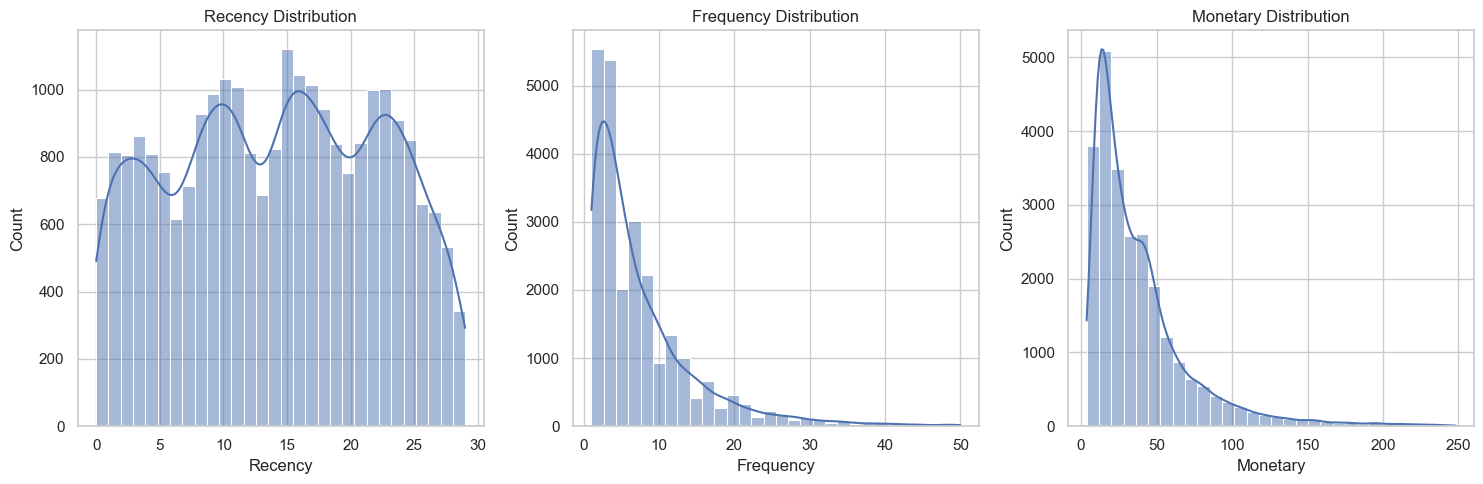

In [233]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.histplot(rfm_df['Recency'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Recency Distribution')

sns.histplot(rfm_df['Frequency'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Frequency Distribution')

sns.histplot(rfm_df['Monetary'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Monetary Distribution')

plt.tight_layout()
plt.show()

> - [ ] the recency shows that lifespan of customers has obviously periodic. To see insider.

## User Segmentation 用户分层
_segment all customers into 2^3=8 sections by LTV from RFM computing_
### segmentation criteria 3Dscatterplot

In [236]:
rfm_df2 = rfm_df.reset_index()
fig = px.scatter_3d(rfm_df2, x='Recency', y='Frequency', z='Monetary', color='RFM_Score',
                    size='RFM_Score', opacity=0.5, size_max=10, hover_name='user_id', #symbol='user_id',
                    title='RFM User Segmentation Cube')

fig.update_layout(scene=dict(xaxis_title='Recency', yaxis_title='Frequency', zaxis_title='Monetary'))
fig.update_layout(width=1000, height=800)

# add straight line to present the 8 subcubes spliting by 50% quantiles above: R-15 F-5 M-28.17
lines_x = [[0,30],[0,30],[0,30],[0,30],[0,30],[0,30],[0,30],[0,30]]
lines_y = [[0,0],[50,50],[0,0],[5,5],[50,50],[0,0],[5,5],[50,50]]
lines_z = [[28.17,28.17],[28.17,28.17],[0,0],[0,0],[0,0],[250,250],[250,250],[250,250]]
for i in range(len(lines_x)):
    fig.add_trace(go.Scatter3d(x=lines_x[i], y=lines_y[i], z=lines_z[i], mode='lines', line=dict(color='black', width=3), name='Line {}'.format(i + 1), showlegend=False))

In [237]:
lines_x = [[0,0],[30,30],[0,0],[15,15],[30,30],[0,0],[15,15],[30,30]]
lines_y = [[0,50],[0,50],[0,50],[0,50],[0,50],[0,50],[0,50],[0,50]]
lines_z = [[28.17,28.17],[28.17,28.17],[0,0],[0,0],[0,0],[250,250],[250,250],[250,250]]
for i in range(len(lines_x)):
    fig.add_trace(go.Scatter3d(x=lines_x[i], y=lines_y[i], z=lines_z[i], mode='lines', line=dict(color='black', width=3), name='Line {}'.format(i + 1), showlegend=False)) 

In [238]:
lines_x = [[15,15],[15,15],[0,0],[0,0],[0,0],[30,30],[30,30],[30,30]]
lines_y = [[0,0],[50,50],[0,0],[5,5],[50,50],[0,0],[5,5],[50,50]]
lines_z = [[0,250],[0,250],[0,250],[0,250],[0,250],[0,250],[0,250],[0,250]]
for i in range(len(lines_x)):
    fig.add_trace(go.Scatter3d(x=lines_x[i], y=lines_y[i], z=lines_z[i], mode='lines', line=dict(color='black', width=3), name='Line {}'.format(i + 1), showlegend=False))

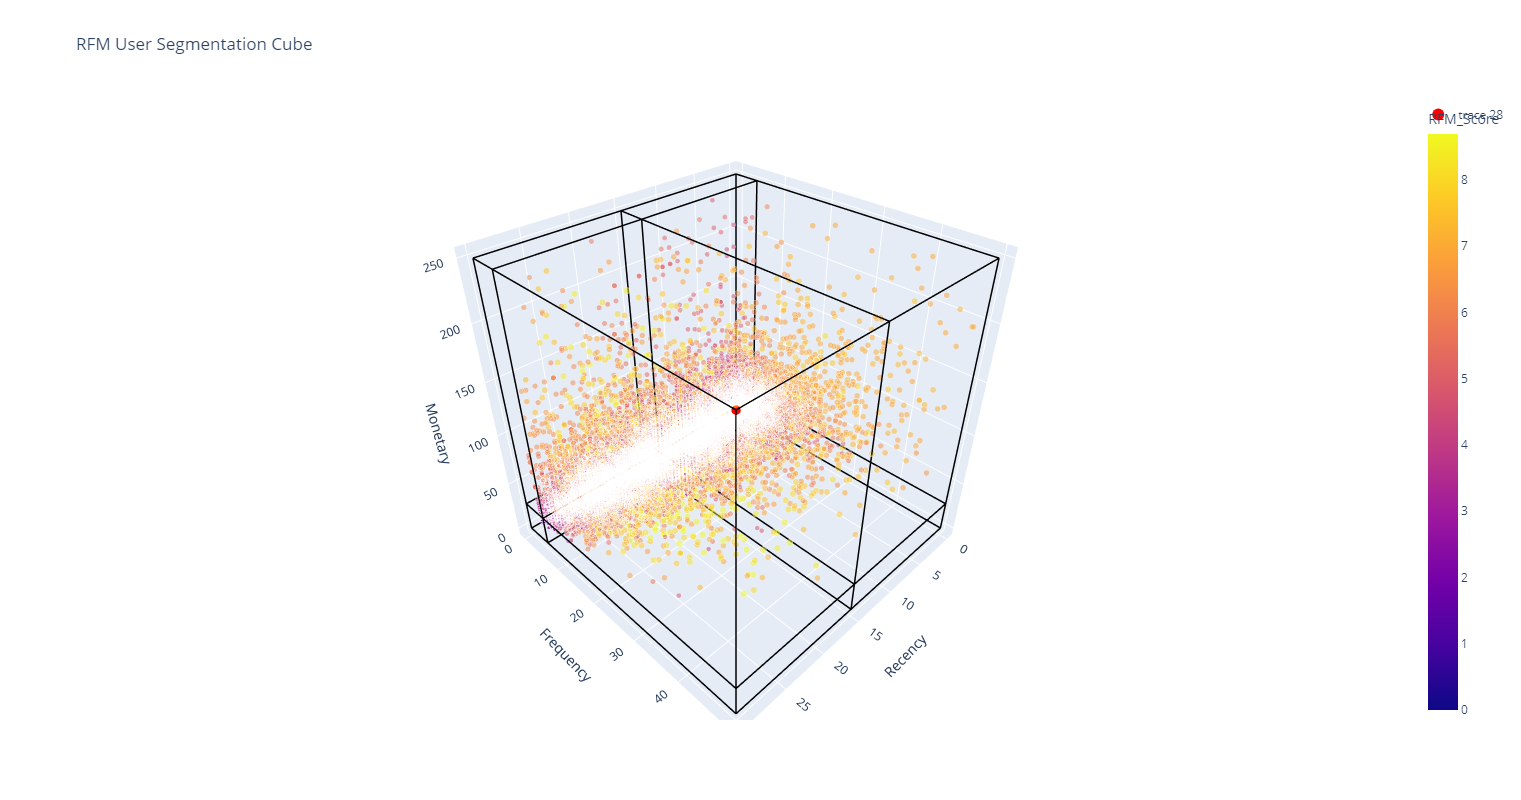

In [239]:
fig.add_trace(go.Scatter3d(x=[15,15], y=[0,50], z=[28.17,28.17], mode='lines', line=dict(color='black', width=3), showlegend=False)) # legendgroup='divide_R', legendrank=1500 , legendgrouptitle={'text':'Segment'}
fig.add_trace(go.Scatter3d(x=[0, 30], y=[5,5], z=[28.17,28.17], mode='lines', line=dict(color='black', width=3), showlegend=False))
fig.add_trace(go.Scatter3d(x=[15, 15], y=[5,5], z=[0, 250], mode='lines', line=dict(color='black', width=3), showlegend=False))

# add center point
fig.add_trace(go.Scatter3d(x=[15], y=[25], z=[125],
                           mode='markers', marker=dict(color='red', size=5),
                           text=['(15,25,125)'], textposition='middle center'))

fig.show()

In [240]:
rfm_df2['group'] = ''
for i in range(0,len(rfm_df2)):
    if rfm_df2['R'][i]<5:
        if rfm_df2['F'][i]<5:
            if rfm_df2['M'][i]<5:
                rfm_df2['group'][i]='000'
            else:
                rfm_df2['group'][i]='001'
        else:
            if rfm_df2['M'][i]<5:
                rfm_df2['group'][i]='010'
            else:
                rfm_df2['group'][i]='011'
    else:
        if rfm_df2['F'][i]<5:
            if rfm_df2['M'][i]<5:
                rfm_df2['group'][i]='100'
            else:
                rfm_df2['group'][i]='101'
        else:
            if rfm_df2['M'][i]<5:
                rfm_df2['group'][i]='110'
            else:
                rfm_df2['group'][i]='111'
rfm_df2['group'] = rfm_df2['group'].astype(str)

In [241]:
rfm_df2

user_id  Recency  Frequency  Monetary  R  F  M  RFM_Score    LTV  \
0      101025416       17         11     62.10  5  6  8       6.80 286.10   
1      103274988        1         17     60.63  0  7  8       6.10 256.65   
2      105075440       22          2     11.30  7  0  1       1.90  79.94   
3      105118203       20          8     39.58  6  5  6       5.70 239.82   
4      105379623        9          6     20.08  2  4  3       3.10 130.43   
...          ...      ...        ...       ... .. .. ..        ...    ...   
24808   98079173       19         14     31.43  6  7  5       5.80 244.03   
24809   99011711       27          4     32.86  9  2  5       4.90 206.16   
24810   99293243       17          7     50.93  5  4  7       5.70 239.82   
24811   99499363        3          8     39.32  0  5  6       4.50 189.33   
24812   99666343       16          1      4.00  5  0  0       1.00  42.07   

      group  
0       111  
1       011  
2       100  
3       111  
4       000  
...     ...  
24808   111  
24809   101  
24810   101  
24811   011  
24812   100  

[24813 rows x 10 columns]

In [242]:
a = [1,0]
b = [1,0]
c=[1,0]

comb = list(product(a, b,c))
gpn_df = pd.DataFrame(np.array(comb), columns=['Rs', 'Fs', 'Ms'])
gpn_df['group'] = gpn_df.apply(lambda row: ''.join(map(str, row)), axis=1)
gpn_df['tags'] = ['champions','promising','potentital_loyalist','newcome','former_loyalist','at_risk','hibernating','almost_lost']
gpn_df['group'] = gpn_df['group'].astype(str)
gpn_df

Rs  Fs  Ms group                 tags
0   1   1   1   111            champions
1   1   1   0   110            promising
2   1   0   1   101  potentital_loyalist
3   1   0   0   100              newcome
4   0   1   1   011      former_loyalist
5   0   1   0   010              at_risk
6   0   0   1   001          hibernating
7   0   0   0   000          almost_lost

In [243]:
gpn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rs      8 non-null      int32 
 1   Fs      8 non-null      int32 
 2   Ms      8 non-null      int32 
 3   group   8 non-null      object
 4   tags    8 non-null      object
dtypes: int32(3), object(2)
memory usage: 356.0+ bytes


In [244]:
rfm_df3 = pd.merge(rfm_df2, gpn_df, on='group', how='left')
# rfm_df3 = rfm_df3.drop(['Rs','Fs','Ms'], axis=1, inplace=True)
rfm_df3

user_id  Recency  Frequency  Monetary  R  F  M  RFM_Score    LTV  \
0      101025416       17         11     62.10  5  6  8       6.80 286.10   
1      103274988        1         17     60.63  0  7  8       6.10 256.65   
2      105075440       22          2     11.30  7  0  1       1.90  79.94   
3      105118203       20          8     39.58  6  5  6       5.70 239.82   
4      105379623        9          6     20.08  2  4  3       3.10 130.43   
...          ...      ...        ...       ... .. .. ..        ...    ...   
24808   98079173       19         14     31.43  6  7  5       5.80 244.03   
24809   99011711       27          4     32.86  9  2  5       4.90 206.16   
24810   99293243       17          7     50.93  5  4  7       5.70 239.82   
24811   99499363        3          8     39.32  0  5  6       4.50 189.33   
24812   99666343       16          1      4.00  5  0  0       1.00  42.07   

      group  Rs  Fs  Ms                 tags  
0       111   1   1   1            champions  
1       011   0   1   1      former_loyalist  
2       100   1   0   0              newcome  
3       111   1   1   1            champions  
4       000   0   0   0          almost_lost  
...     ...  ..  ..  ..                  ...  
24808   111   1   1   1            champions  
24809   101   1   0   1  potentital_loyalist  
24810   101   1   0   1  potentital_loyalist  
24811   011   0   1   1      former_loyalist  
24812   100   1   0   0              newcome  

[24813 rows x 14 columns]

### user tags distribution multichart

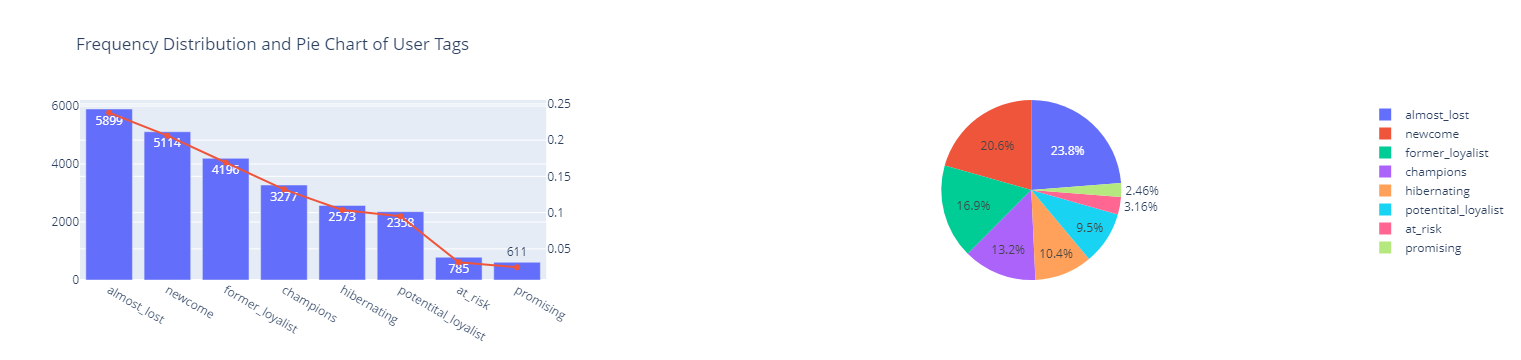

In [246]:
s = rfm_df3['tags'].value_counts()
# fig = px.bar(s, y=s.values, x=s.index, text_auto='.2s',title="User Tags Distribution") #, subtitle='see how many users in each tag')
# fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
# fig.show()
freq = s / s.sum()
formatted = ['{:.2%}'.format(i) for i in freq.values]
# 创建频率分布直方图
fig1 = go.Figure([go.Bar(x=s.index, y=s.values, text=s.values, hoverinfo='none', textposition='auto', yaxis='y1', showlegend=False),
                  go.Scatter(x=s.index, y=freq, hoverinfo='x+text', text=formatted, mode='lines+markers', yaxis='y2', showlegend=False)])
fig1.update_layout(
    title='Frequency Distribution of User Tags',
    xaxis_title='Tags',
    yaxis_title='User Count',
    yaxis2=dict(title='Segment Percentage', overlaying='y', side='right'), overwrite=True)

fig2 = go.Figure(go.Pie(labels=s.index, values=s.values, showlegend=True))
# test=go.histogram(kde=)
# create a layout with [1,2] grid
fig = make_subplots(rows=1, cols=2, column_widths=[0.5, 0.5], specs=[[{"type": "xy","secondary_y":True}, {"type": "domain"}]]) 
# ↑ has to set "secondary_y":True here to let the below one effective

# add subplots into grid
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig1.data[1], row=1, col=1, secondary_y=True)
fig.add_trace(fig2.data[0], row=1, col=2)
fig.update_layout(title_text="Frequency Distribution and Pie Chart of User Tags")

fig.show()

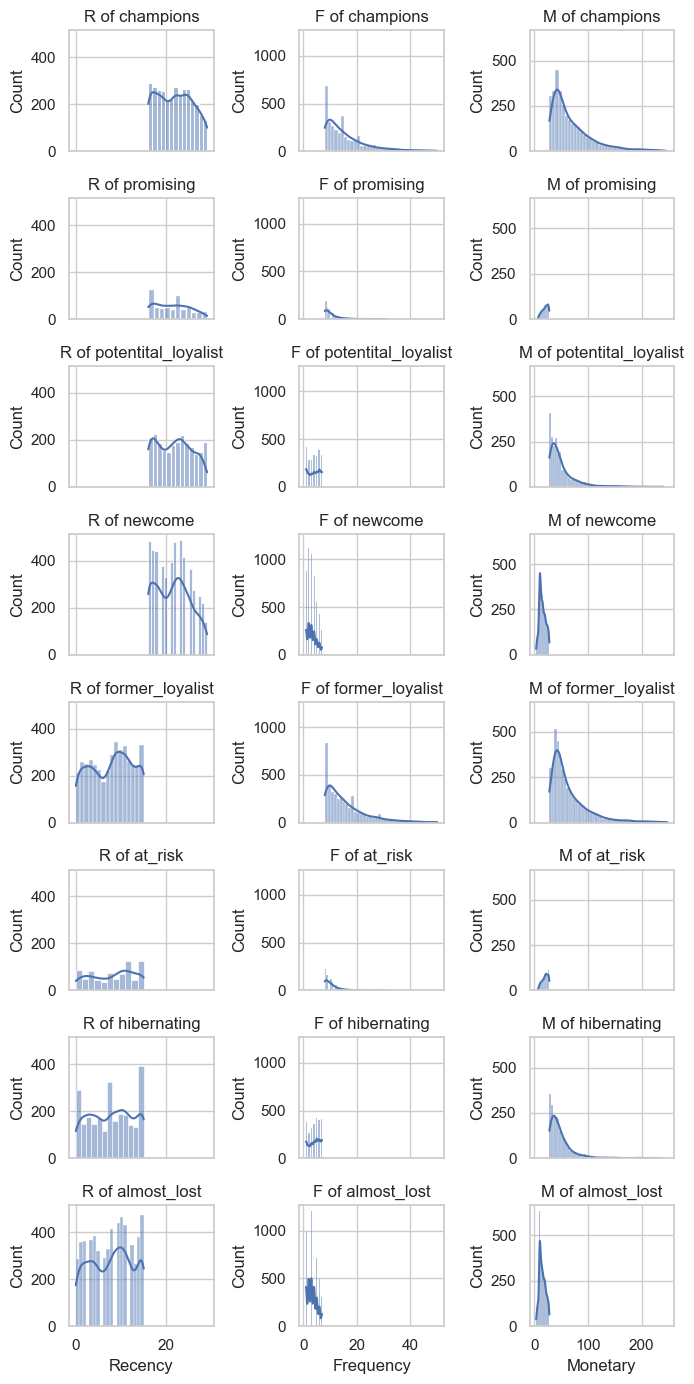

In [247]:
fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(7, 14), sharex='col', sharey='col')
tags = ['champions','promising','potentital_loyalist','newcome','former_loyalist','at_risk','hibernating','almost_lost']
types = ['Recency','Frequency','Monetary']
for r in range(0,8,1):
    for l in range(0,3,1):
        tag = tags[r]
        type = types[l]
        sns.histplot(rfm_df3[rfm_df3['tags']==tag][type], kde=True, ax=axes[r,l]) # bins=30, 
        axes[r,l].set_title(f'{type[0]} of {tag}')
plt.tight_layout()
plt.show()

#### segmentation insights
**For User Refined Operation later:**
- **almost_lost** indicates similar things to churn_rate of which corresponding part of customers has been already included in, which indicates the **unhealthy user structure** of the platform. I need more details of profit/revenue tables from database and ARPU/ARPPU to determine about "unhealthy".
- **champions** are best. I think maybe we can reward them in diverse ways for early utilization of new functions/products and referral in return.
- Providing **potential_loyalists** a higher_grade of membership or loyalty programs like everyday clock for credits or recommend campaigns to upsell them.
- **newcome**  needs us to start building relationships with them. Like onboarding support and special offers for new customers to increase their orders, to form a using habit.
- Sending to **hibernating** personalized reactivation campaigns to reactivate, and offer renewals and helpful products to encourage another purchase.
- Bringing **former_loaylist** back with relevant promotions, and running surveys to find out what went wrong and avoiding losing them to competitors.
- **promising** obviously loves cheaper products, notifying them about the discounts of cart or things they've viewed once in time to keep them spending more and more money on our products

#This is a glimpse of how we can target a customer based on the segmentation which will precisely help in marketing campaigns. Thus saving marketing costs, retaining the customer, making them spend more thereby increasing the revenue. The details are up to the real_world scenarios.

# **PLATFORM ANALYSIS**
_by user_session_
***

小结：用户消费行为总览（按日维度）
* 总体指标总览
mean_daily_pv=10000.00
mean_daily_uv=1450.00
mean_daily_gmv=84519.37
mean_daily_order=59
mean_daily_paid_user=59
mean_daily_paid_rate=4.07%
mean_daily_ARPU=58.29
mean_daily_ARPPU=1432.53
* 从daily_pv&daily_uv图表可以看出，该月内用户量、访问量整体呈现缓慢攀升的趋势，在双十二达到峰值
* 从hourly_pv&hourly_uv图表可以看出，总体来看23:00与次日5:00的访问量在下降，5:00后开始回升至正常水平，18:00-22:00访问量有明显提升，并在21:00-22:00达到峰值，用户量的趋势类似但不那么明显；区分用户活跃时段，一般活跃时段及非活跃时段

## User Engagement

### daily engagement of platform
_daily distribution of user action to see if there's regular pattern in a month 用户行为日分布_

In [97]:
total_uv=data['user_id'].value_counts()
print(total_uv)
total_uv=len(total_uv)
print('total_uv='+str(total_uv))
total_pv=len(data['user_id'])
print('total_pv='+str(total_pv))

user_id
527021202    8689
572631412    3883
467810091    3147
548810441    2426
584289031    2356
             ... 
561547151       1
586485554       1
586486068       1
363648439       1
595414541       1
Name: count, Length: 370154, dtype: int64
total_uv=370154
total_pv=3533286


In [98]:
date=[]
hour=[]

for i in range(0,3533286):
    split_time=str(data['event_time'][i]).split(' ')
    for a in split_time:
        if "-" in a:
            date.append(a)
        elif ":" in a:
            hour.append(a)
#print(date,hour)

In [99]:
data['date']=date
data['hour']=hour
# del data['event_time']
print(data['date'].tail(10))

3533276    2019-12-31
3533277    2019-12-31
3533278    2019-12-31
3533279    2019-12-31
3533280    2019-12-31
3533281    2019-12-31
3533282    2019-12-31
3533283    2019-12-31
3533284    2019-12-31
3533285    2019-12-31
Name: date, dtype: object


In [100]:
# 日流量指标
daily_pv=data[data.event_type=='view'].groupby('date')['user_id'].count().reset_index().rename(columns={'user_id':'pv'})
daily_uv=data.groupby('date').nunique()['user_id'].reset_index().rename(columns={'user_id':'uv'})
print(daily_pv,'\n',daily_uv)

          date     pv
0   2019-12-01  59528
1   2019-12-02  64921
2   2019-12-03  63503
3   2019-12-04  65472
4   2019-12-05  61445
5   2019-12-06  56883
6   2019-12-07  53910
7   2019-12-08  57435
8   2019-12-09  73983
9   2019-12-10  68677
10  2019-12-11  69931
11  2019-12-12  65577
12  2019-12-13  59932
13  2019-12-14  53099
14  2019-12-15  60275
15  2019-12-16  67282
16  2019-12-17  63779
17  2019-12-18  64313
18  2019-12-19  58848
19  2019-12-20  49265
20  2019-12-21  49525
21  2019-12-22  52169
22  2019-12-23  58344
23  2019-12-24  54577
24  2019-12-25  54129
25  2019-12-26  46670
26  2019-12-27  41300
27  2019-12-28  41477
28  2019-12-29  40668
29  2019-12-30  34198
30  2019-12-31  17216 
           date     uv
0   2019-12-01  17540
1   2019-12-02  19391
2   2019-12-03  18735
3   2019-12-04  18836
4   2019-12-05  18183
5   2019-12-06  16948
6   2019-12-07  15508
7   2019-12-08  16835
8   2019-12-09  19777
9   2019-12-10  19336
10  2019-12-11  20128
11  2019-12-12  18920
12  2019

Text(0.5, 1.0, 'daily_uv')

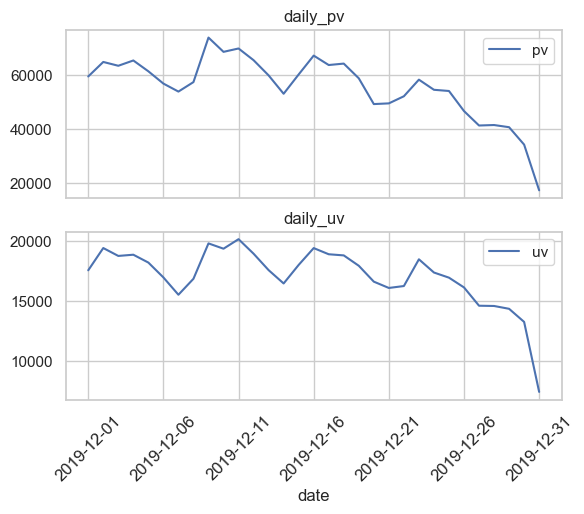

In [101]:
ax1=plt.subplot(2,1,1,label='daily_pv')
ax2=plt.subplot(212,sharex=ax1,label='daily_uv')
# fig,axes=plt.subplots(2,1,1,figsize=(12,8),sharex='all')
daily_pv.plot(x='date',y='pv',ax=ax1)
daily_uv.plot(x='date',y='uv',ax=ax2)
plt.xticks(rotation=45,fontsize=12)
ax1.set_title('daily_pv')
ax2.set_title('daily_uv')

### hourly engagement of platform
_timely distribution of user action to see if there exists pattern in a day 用户行为时分布_

In [103]:
#小时流量指标
# for i in data.columns[:2]:
#     data[i]=data[i].astype('str')
# data['date']=pd.to_datetime(data.date)
# data['hour']=data.hour.astype('int')
hour_int=[]
for i in hour:
    hour_int.append(i[0:2])
# print(hour_int[:10])

In [104]:
data['hour_int']=hour_int
pv_hour=data[data.event_type=='view'].groupby('hour_int').count()['user_id'].reset_index(drop=True)
uv_hour.columns=['hour','pv']
uv_hour=data.groupby('hour_int').nunique()['user_id'].reset_index(drop=True)   # .rename(columns={'user_id':'uv'})一直显示rename有个unexpected keyword kwarg columns
uv_hour.columns=['hour','uv']
print(pv_hour,'\n',uv_hour)

NameError: name 'uv_hour' is not defined

In [ ]:
fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(12,8),sharex=True)
pv_hour.plot(ax=axes[0])
uv_hour.plot(ax=axes[1])
axes[0].set_title('pv_hour')
axes[1].set_title('uv_hour')
axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
axes[1].xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()

In [ ]:
mean_daily_pv=data[data.event_type=='view'].groupby('date')['user_id'].count().mean()
print('mean_daily_pv='+str('%.2f'%mean_daily_pv))
mean_daily_uv=data.groupby('date').nunique()['user_id'].mean()
print('mean_daily_uv='+str('%.2f'%mean_daily_uv))
mean_daily_gmv=data.groupby('date')['price'].sum().mean()
print('mean_daily_gmv='+str('%.2f'%mean_daily_gmv))
mean_daily_order=data[data.event_type=='purchase'].groupby('date').nunique()['user_session'].values.mean() #series.values访问频数，.index访问索引
print('mean_daily_order='+str('%.0f'%mean_daily_order))
mean_daily_paid_user=data[data.event_type=='purchase'].groupby('date').nunique()['user_id'].mean()
print('mean_daily_paid_user='+str('%.0f'%mean_daily_paid_user))
mean_daily_paid_rate=(mean_daily_paid_user/mean_daily_uv)*100
print('mean_daily_paid_rate='+str('%.2f'%mean_daily_paid_rate)+'%')
mean_daily_ARPU=(mean_daily_gmv/mean_daily_uv)
print('mean_daily_ARPU='+str('%.2f'%mean_daily_ARPU))
mean_daily_ARPPU=(mean_daily_gmv/mean_daily_paid_user)
print('mean_daily_ARPPU='+str('%.2f'%mean_daily_ARPPU))

In [ ]:
mean_daily_pv=data.groupby('date')['user_id'].count().mean()
print('mean_daily_pv='+str('%.2f'%mean_daily_pv))
mean_daily_uv=data.groupby('date').nunique()['user_id'].mean()
print('mean_daily_uv='+str('%.2f'%mean_daily_uv))
mean_daily_gmv=data.groupby('date')['price'].sum().mean()
print('mean_daily_gmv='+str('%.2f'%mean_daily_gmv))
mean_daily_order=data[data.event_type=='purchase'].groupby('date').nunique()['user_session'].values.mean() #series.values访问频数，.index访问索引
print('mean_daily_order='+str('%.0f'%mean_daily_order))
mean_daily_paid_user=data[data.event_type=='purchase'].groupby('date').nunique()['user_id'].mean()
print('mean_daily_paid_user='+str('%.0f'%mean_daily_paid_user))
mean_daily_paid_rate=(mean_daily_paid_user/mean_daily_uv)*100
print('mean_daily_paid_rate='+str('%.2f'%mean_daily_paid_rate)+'%')
mean_daily_ARPU=(mean_daily_gmv/mean_daily_uv)
print('mean_daily_ARPU='+str('%.2f'%mean_daily_ARPU))
mean_daily_ARPPU=(mean_daily_gmv/mean_daily_paid_user)
print('mean_daily_ARPPU='+str('%.2f'%mean_daily_ARPPU))

小结：用户消费行为总览
* 总体指标概览
mean_daily_pv=10000.00
mean_daily_uv=1450.00
mean_daily_gmv=84519.37
mean_daily_order=59
mean_daily_paid_user=59
mean_daily_paid_rate=4.07%
mean_daily_ARPU=58.29
mean_daily_ARPPU=1432.53

（以上是1w条预分析的结论）


* 总体指标概览 :joy:
mean_daily_pv=55752.61
mean_daily_uv=17065.32
mean_daily_gmv=1011187.26
mean_daily_order=934
mean_daily_paid_user=919
mean_daily_paid_rate=5.39%
mean_daily_ARPU=59.25
mean_daily_ARPPU=1100.31
* 从daily_pv&daily_uv图表可以看出，该月内用户量、访问量几乎同幅变动，整体呈现逐渐下降的趋势，在12.2、12.9两个预售日节点有明显小高峰，12.12活动当天达到峰值，紧接着有2-3天的冷却期，之后12.16、12.23有返潮现象
* 周末活跃度明显高于其它工作日，故营销活动或宣发应在周末进行
* 从pv_hour&uv_hour图表可以看出，总体来看19:00-次日2:00的访问量在下降，2:00后开始回升,7:00至正常水平，每日的12:00、19:00达到峰值，反映出午餐及下班后时间更适宜搞平台运营动作
* 用户活跃时段9:00-13:00、17:00-20:00，一般活跃时段13:00-17:00、5:00-9:00，,非活跃时段20:00-5:00

## Conversion Rate in Finer Granularity
_accurate user action flow funnel on consideration of accordant user_id & user_session from beginning to end. 用户行为精准追踪漏斗_

### total conversion rate
_total conversion rate in the user flow path 计算用户流转链路中的总转化率_

In [ ]:
event_type_df

In [ ]:
view=data[data.event_type=='view']
cart=data[data.event_type=='cart']
purchase=data[data.event_type=='purchase']
remove=data[data.event_type=='remove from cart']

In [ ]:
view_num=view.user_id.nunique()
cart_num=cart.user_id.nunique()
purchase_num=purchase.user_id.nunique()
remove_num=remove.user_id.nunique()
view_num

In [ ]:
funnel_data=[("浏览",view_num),("加购",cart_num),("付费",purchase_num)]
(Funnel(init_opts=opts.InitOpts(width='500px',height='300px')).add(
    "type",data_pair=funnel_data,label_opts=opts.LabelOpts(),gap=1,tooltip_opts=opts.TooltipOpts(is_show=True)).set_global_opts(
        title_opts=opts.TitleOpts(title="用户转化漏斗",subtitle="process:浏览-加购-付费"))
).render_notebook()

In [ ]:
# 计算总转化率（即默认用户先浏览后加购后购买）
purchase_user=data[data.event_type=='purchase'].user_id.nunique()
remove_user=data[data.event_type=='remove_from_cart'].user_id.nunique()
print('浏览后加购率%.2f%%'%((cart_user/view_user)*100))
print('加购后付费率%.2f%%'%((purchase_user/cart_user)*100))
print('加购后移除率%.2f%%'%((remove_user/cart_user)*100))
print('总uv中浏览人占比%.2f%%'%((view_user/total_uv)*100))
print('总uv中加购人占比%.2f%%'%((cart_user/total_uv)*100))
print('总uv中购买人占比%.2f%%'%((purchase_user/total_uv)*100))

小结：用户转化漏斗分析
* ps此处的处理方式是由于①并未能保证用户均是按照理想链路流转，因此不能直接除以，需要合并求交叉值，并控制时间先后才能确保结果是我们所需的“精准”的流转链路。
* 进一步释义：合并后的记录有630243条，这意味着有（927124-630243）位用户是未浏览详情页直接加购的，view2cart_user=52979，有（630243-52979）位用户不是在周期内形成view→cart完整链路的。
* 层级转化率：浏览的人中有14.79%加购，加购的人中有30.17%付费，浏览的人中有5.94%直接付费。
* 总转化率中用“模糊”形式得到了23.30%和30.69%，相对来说都是偏大的。
* 总活跃用户中各种行为的uid占比，结合前方的层级转化可见，大部分用户还是停留在浏览的一个阶段，需要运营在该转化节点加力。对应举措（1）运营多多筹办积分活动、会员活动、促销活动等促使用户尽快加购付费；（2）用户增长可以拓展站外流量来源，增加点击量；（3）产品可以增加醒目的加购提醒或降价/秒杀消息通知等。

### level conversion rate 
_conversion rate of each level, in finer granularity, in the user flow path 计算用户流转链路中的层级转化率_

In [ ]:
view2cart=pd.merge(left=view,right=cart,how='inner',on=['user_id','product_id'],suffixes=("_view","_cart"))
cart2purchase=pd.merge(left=cart,right=purchase,how='inner',on=['user_id','product_id'],suffixes=("_cart","_purchase"))
view2purchase=pd.merge(left=view,right=purchase,how='inner',on=['user_id','product_id'],suffixes=("_view","_purchase"))
view2cart

In [ ]:
# view2cart['event_time_view']=pd.toDatetime()
view2cart_user=view2cart[view2cart.event_time_view<view2cart.event_time_cart].user_id.nunique()
cart2purchase_user=cart2purchase[cart2purchase.event_time_cart<cart2purchase.event_time_purchase].user_id.nunique()
view2purchase_user=view2purchase[view2purchase.event_time_view<view2purchase.event_time_purchase].user_id.nunique()
print(view2cart_user,cart2purchase_user,view2purchase_user)
view_user=data[data.event_type=='view'].user_id.nunique()
cart_user=data[data.event_type=='cart'].user_id.nunique()
# 计算层级转化率
view2cart_rate=view2cart_user/view_user
cart2purchase_rate=cart2purchase_user/cart_user
view2purchase_rate=view2purchase_user/view_user
print('浏览加购层级转化率%.2f%%'%(view2cart_rate*100))
print('加购付费层级转化率%.2f%%'%(cart2purchase_rate*100))
print('浏览付费层级转化率%.2f%%'%(view2purchase_rate*100))

In [ ]:
print(user_event_count)

## Retention Rate
_partion of users keeping active in a time range, standing for appeal to users 一定时间内保持活跃状态的用户比例，反映产品和平台服务的的吸引力_
- 7d_rtt
- 15d_rtt
- 30d_rtt

## User Stickiness
_using frequency and duration of platform, standing for dependency degree of users 对产品或服务的使用频率和持续时间_
- using frequency: event_times not buy_times
- duration of platform: event lifespan not purchase lifespan defined earlier

# **BRAND AND PRODUCT ANALYSIS**
_by brand/product_id_
***

## Performance of Brands
- heat = how times a brand appeared in the event_table and how many customers engaged with it  -> top_heat
- spec_times = specific times in view/cart/purchase of a brand  ->  top_view/top_cart/top_buy/top_rm
- user_loyalty = view/cart/purchase_times/value_peruser of each brand  ->  top_loyalty_brand
- brand_gmv = total order_value of a brand, just purchase (# avg_order_value(AOV) != product_price(unit_price), just related in deed. -> top_gmv客单价不等于产品单价，只是相关)
- AOV = average order value, just purchase make sense  ->top_AOV
- avg_unit_price = average product price of each brand to see if it's a luxury brand aiming at upscale market or affordable one aiming at lower-tier market  -> top_dear_brand
- product_diversiity = how many kinds of products a brand have  ->  top_div_brand
- profitability (need product_tb with profit from database)

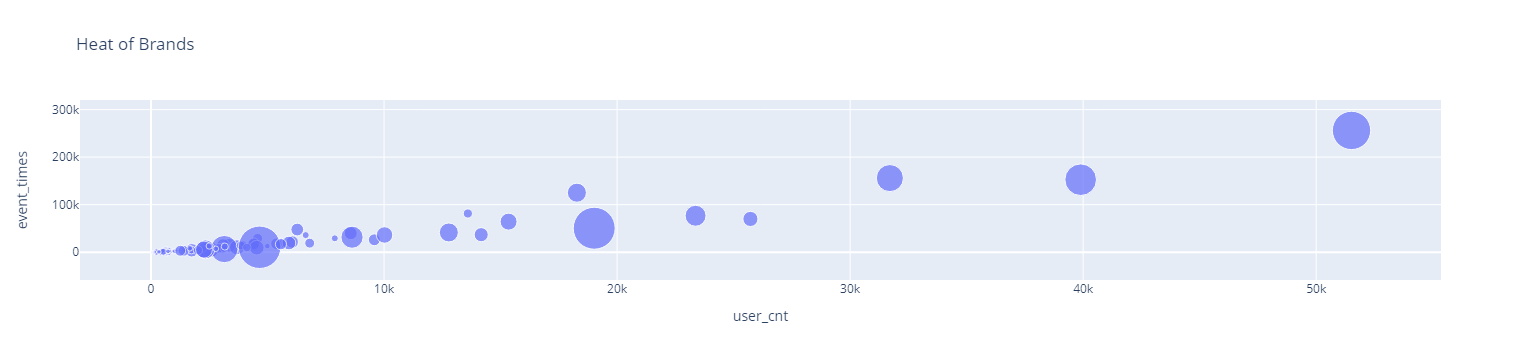

event_times  event_value  gross_event_volume  user_cnt
brand                                                             
airnails          14430        15.14           218454.56      3356
almea               826        27.33            22578.49       462
andrea               90         5.54              498.60        60
ardell             4969         6.49            32264.72      1964
art-visage        10704         3.02            32298.38      4010
...                 ...          ...                 ...       ...
ypsed               416        23.44             9749.93       181
yu-r                669        34.22            22895.02       343
zab                  21        16.96              356.07        13
zeitun             1847        13.42            24786.22       727
zinger            19001         6.04           114835.84      6809

[252 rows x 4 columns]

In [302]:
brand_df = data[data.brand!='null'].groupby('brand').agg({'product_id': 'count', 'price': ['mean','sum'], 'user_id': pd.Series.nunique}) # brand_df['order_value'] = data[data.event_type=='purchase']
brand_df.columns = ['event_times','event_value','gross_event_volume','user_cnt'] # brand_df.columns.droplevel(0)
# , 'category_id': lambda x: ','.join(x.unique())

fig = px.scatter(brand_df, x='user_cnt', y='event_times', size="gross_event_volume", 
                 labels={'heat':'event_times','user_cnt':'user_cnt'}, 
                 hover_name=brand_df.index, size_max=30, title='Heat of Brands')
# hover_data={'price': True}, color="continent",  log_x=True,
fig.show()
brand_df

In [304]:
top_event_value = brand_df.sort_values(by='event_value',ascending=False).head(20)
top_event_value
top_gev = brand_df.sort_values(by='gross_event_volume',ascending=False).head(20)
top_gev

event_times  event_value  gross_event_volume  user_cnt
brand                                                            
strong           10305       204.02          2102395.01      4659
jessnail         50383        40.78          2054767.03     19018
runail          256217         6.70          1716416.72     51516
irisk           152518         7.67          1169752.29     39894
marathon          6553       132.58           868768.17      3145
grattol         155920         5.49           856684.06     31705
cnd              31530        18.14           572103.23      8626
estel            76649         6.70           513535.16     23367
masura          125185         3.40           425557.82     18275
uno              41507        10.16           421874.90     12780
max               5961        70.39           419586.76      2331
ingarden         64273         5.24           336664.62     15344
polarus           5533        60.52           334850.56      2272
italwax          36172         8.76           316981.46     10021
kosmekka          3467        88.89           308178.84      2346
jas               5304        51.02           270600.15      2573
kapous           69935         3.82           267171.52     25721
browxenna        10286        25.73           264640.50      3690
shik              9562        26.03           248931.69      4537
concept          36831         6.28           231269.43     14169

In [306]:
brand_event_df = data[data.brand!='null'].groupby(['brand', 'event_type']).agg({'product_id':'count', 'user_id': 'nunique','price':['mean','sum']})
brand_event_df.columns = ['spec_times','user_cnt','AOV','gmv']
# .rename(columns={'product_id':'spec_times','user_id':})
# pd.Series.nunique
brand_event_df['spec_times_peruser'] = brand_event_df['spec_times'] / brand_event_df['user_cnt']
# brand_event_df['AOV'] = brand_event_df['gmv'] / brand_event_df['spec_times']
brand_event_df['gmv_peruser'] = brand_event_df['gmv'] / brand_event_df['user_cnt']
brand_event_df

spec_times  user_cnt   AOV       gmv  \
brand    event_type                                               
airnails cart                    4726      1048  3.38  15974.28   
         purchase                1378       360  2.98   4113.27   
         remove_from_cart        2996       615  3.44  10316.34   
         view                    5330      2723 35.28 188050.67   
almea    cart                     115        74 24.97   2871.87   
...                               ...       ...   ...       ...   
zeitun   view                    1152       625 14.11  16250.26   
zinger   cart                    5063      2559  4.30  21781.02   
         purchase                1313      1011  4.29   5626.71   
         remove_from_cart        2855      1337  4.77  13620.25   
         view                    9770      5100  7.55  73807.86   

                           spec_times_peruser  gmv_peruser  
brand    event_type                                         
airnails cart                            4.51        15.24  
         purchase                        3.83        11.43  
         remove_from_cart                4.87        16.77  
         view                            1.96        69.06  
almea    cart                            1.55        38.81  
...                                       ...          ...  
zeitun   view                            1.84        26.00  
zinger   cart                            1.98         8.51  
         purchase                        1.30         5.57  
         remove_from_cart                2.14        10.19  
         view                            1.92        14.47  

[933 rows x 6 columns]

In [307]:
brand_event_df.reset_index(inplace=True)

top_view = brand_event_df[brand_event_df['event_type']=='view'].sort_values(by='spec_times', ascending=False)
top_cart = brand_event_df[brand_event_df['event_type']=='cart'].sort_values(by='spec_times', ascending=False)
top_buy = brand_event_df[brand_event_df['event_type']=='purchase'].sort_values(by='spec_times', ascending=False)
top_rm_from_cart = brand_event_df[brand_event_df['event_type']=='remove_from_cart'].sort_values(by='spec_times', ascending=False)
# top_order_value = brand_event_df[brand_event_df['event_type']=='purchase'].sort_values(by='event_value', ascending=False)
top_gmv = brand_event_df[brand_event_df['event_type']=='purchase'].sort_values(by='gmv', ascending=False)
top_AOV = brand_event_df[brand_event_df['event_type']=='purchase'].sort_values(by='AOV', ascending=False)

print('top_view:\n',top_view.head(20),
      '\n\ntop_cart:\n',top_cart.head(20),
      '\n\ntop_buy:\n',top_buy.head(20),
      '\n\ntop_rm_from_cart:\n',top_rm_from_cart.head(20),
      '\n\ntop_AOV:\n',top_AOV.head(20),
      '\n\ntop_gmv:\n',top_gmv.head(20)
     )

top_view:
           brand event_type  spec_times  user_cnt   AOV        gmv  \
774      runail       view      108097     42531 11.32 1224087.25   
365     grattol       view       83257     26828  5.55  462260.81   
415       irisk       view       66529     31231 12.96  862067.48   
598      masura       view       50363     14501  4.27  215131.46   
450      kapous       view       45225     23731  3.80  171723.96   
290       estel       view       44300     20939  7.20  318891.29   
431    jessnail       view       34913     17437 51.54 1799358.13   
124   bpw.style       view       34371     10476  1.21   41444.78   
398    ingarden       view       28253     11458  5.87  165771.46   
153     concept       view       23363     12625  6.68  156160.82   
884         uno       view       20343      9863  9.99  203314.25   
145         cnd       view       20275      7666 19.94  404324.81   
726        pole       view       19346      4765  4.05   78342.68   
419     italwax       v

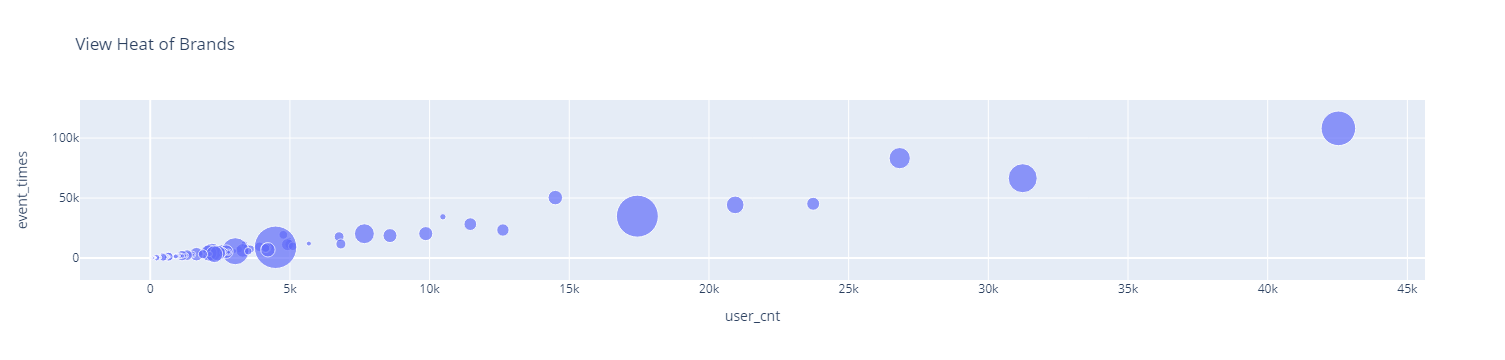

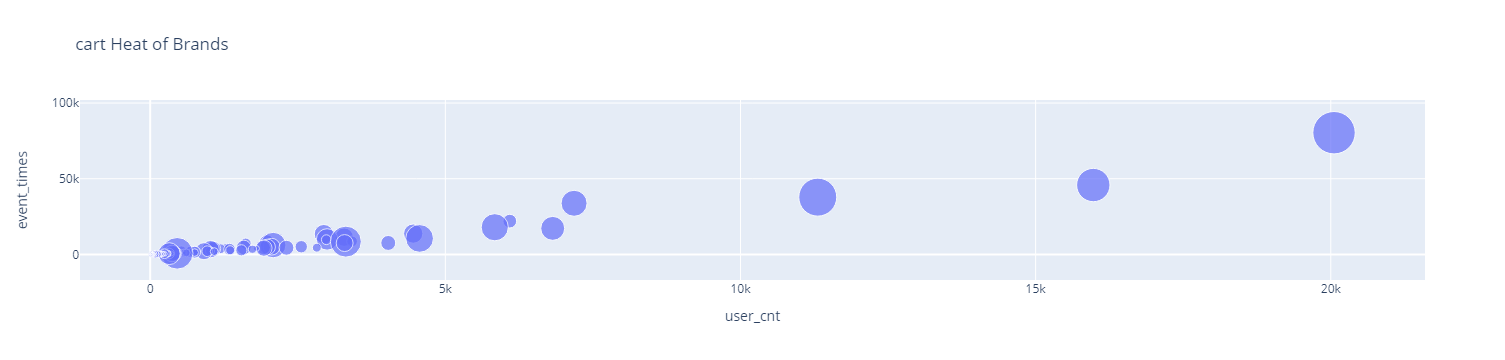

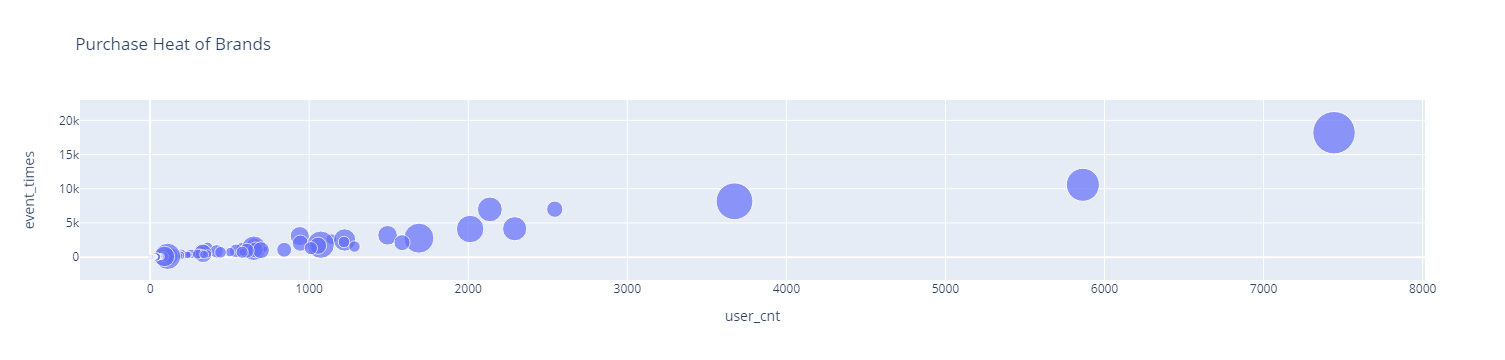

In [308]:
fig = px.scatter(top_view, x='user_cnt', y='spec_times', size="gmv", 
                 labels={'spec_times':'event_times','user_cnt':'user_cnt'}, 
                 hover_name=top_view.brand, size_max=30, title='View Heat of Brands')
fig.show()
fig = px.scatter(top_cart, x='user_cnt', y='spec_times', size="gmv", 
                 labels={'spec_times':'event_times','user_cnt':'user_cnt'}, 
                 hover_name=top_cart.brand, size_max=30, title='cart Heat of Brands')
fig.show()
fig = px.scatter(top_buy, x='user_cnt', y='spec_times', size="gmv", 
                 labels={'spec_times':'event_times','user_cnt':'user_cnt'}, 
                 hover_name=top_buy.brand, size_max=30, title='Purchase Heat of Brands')
fig.show()

In [312]:
# top_loyalty_brand = pd.merge(top_view.nlargest(20, 'event_value'),top_view.nlargest(20, 'spec_times_peruser'),how='inner')
top_loyalty_brand = pd.concat([top_view.nlargest(20, 'spec_times_peruser'),top_cart.nlargest(20, 'spec_times_peruser'),top_buy.nlargest(20, 'spec_times_peruser')], axis=0)
top_loyalty_brand

brand event_type  spec_times  user_cnt   AOV        gmv  \
880        trind       view        2620       446  9.52   24944.35   
726         pole       view       19346      4765  4.05   78342.68   
598       masura       view       50363     14501  4.27  215131.46   
377     haruyama       view       11533      3368  3.98   45882.58   
124    bpw.style       view       34371     10476  1.21   41444.78   
646        moyou       view         606       195  8.17    4950.26   
365      grattol       view       83257     26828  5.55  462260.81   
339    freedecor       view       15187      4974  1.90   28798.70   
889       uskusi       view        4906      1743  3.74   18367.83   
61       beautix       view        7122      2552 12.77   90951.78   
190    dartnails       view        4278      1597  1.33    5678.66   
145          cnd       view       20275      7666 19.94  404324.81   
114      bluesky       view       17802      6761  5.58   99328.76   
481     kinetics       view        5074      1988 10.64   53978.08   
774       runail       view      108097     42531 11.32 1224087.25   
770     roubloff       view        5984      2403  5.79   34642.01   
742       provoc       view        1312       527  6.46    8470.70   
398     ingarden       view       28253     11458  5.87  165771.46   
306        f.o.x       view        8513      3463  7.29   62089.37   
682         oniq       view        9385      3911  9.90   92942.54   
818        soleo       cart         970       173  0.85     823.32   
595       masura       cart       33788      7181  2.85   96216.74   
723         pole       cart       13452      2941  3.88   52177.19   
0       airnails       cart        4726      1048  3.38   15974.28   
647     nagaraku       cart        7134      1617  2.45   17484.64   
38      balbcare       cart         598       139  3.17    1895.66   
374     haruyama       cart        8007      1979  3.95   31648.61   
771       runail       cart       80411     20055  3.18  255856.19   
187    dartnails       cart        4952      1282  1.33    6579.76   
121    bpw.style       cart       21995      6092  1.22   26733.78   
849    swarovski       cart        2671       750  3.14    8373.90   
319     farmstay       cart        2490       703  2.49    6204.44   
679         oniq       cart        3763      1065  8.70   32729.51   
478     kinetics       cart        1846       527 10.07   18590.89   
111      bluesky       cart       11393      3287  4.20   47863.54   
58       beautix       cart        3487      1024 12.17   42438.18   
362      grattol       cart       37841     11309  5.42  205024.94   
416      italwax       cart        9916      2997  6.59   65356.76   
899        vosev       cart          85        26 59.90    5091.40   
845     supertan       cart         209        64  0.95     199.35   
744       radius   purchase           4         1 22.06      88.24   
1       airnails   purchase        1378       360  2.98    4113.27   
724         pole   purchase        3080       941  3.84   11813.66   
596       masura   purchase        6985      2136  2.84   19809.19   
241     egomania   purchase           3         1 13.65      40.96   
122    bpw.style   purchase        7014      2544  1.22    8559.82   
375     haruyama   purchase        1750       654  3.97    6947.25   
850    swarovski   purchase         790       316  2.93    2312.51   
367       greymy   purchase          10         4 33.39     333.95   
479     kinetics   purchase         393       160  9.89    3887.81   
772       runail   purchase       18199      7443  3.20   58177.26   
320     farmstay   purchase         578       241  1.78    1028.01   
543    levissime   purchase         304       130  4.95    1504.80   
59       beautix   purchase         761       326 12.05    9166.87   
874  treaclemoon   purchase          49        21  5.70     279.15   
819        soleo   purchase         172        74  0.87     150.35   
337    freedecor   pu

> top view/cart/purchase sorted by spec_times(ttl): represents the overall level of attention/interest/closed_order and exposure that a brand receives, reflecting the cumulative impact and visibility of the entity inthe market.
> 
> top view/cart/purchase sorted by spec_times_peruser: average views that each user contributes, indicating the level of individual engagement and interest. It provides insights into the depth of user interaction and interest in the entity.

In [315]:
# data['product_id'].nunique() - data[data['brand']=='null']['product_id'].nunique()
# data[(data.brand=='airnails') & (data.product_id=='5659761')]
# I found that some product_id have multiple price so i make it to mode() appeared in the first time

def first_mode(x):
    return x.mode().iloc[0]

pd_df = data[data.brand!='null'].groupby(['brand','product_id']).agg({'price': first_mode}) # pd.Series.mode
product_diversity = pd_df.groupby(level=0).count().sort_values(by='price',ascending=False).head(20).rename(columns={'price':'product_cnt'})
product_diversity
top_div_brand = product_diversity.sort_values(by='product_cnt',ascending=False).head(20)
top_div_brand

product_cnt
brand                 
masura            1536
irisk             1468
runail            1313
estel              856
bluesky            793
freedecor          789
uskusi             640
milv               603
pole               589
oniq               567
ingarden           549
lianail            546
cnd                521
f.o.x              516
haruyama           467
solomeya           352
lovely             340
pnb                332
grattol            326
beautix            324

In [319]:
avg_unit_price =  pd_df.groupby(level=0).mean().sort_values(by='price',ascending=False)
top_unit_price = avg_unit_price.head(20)
top_unit_price
# avg_unit_price['price_numeric'] = pd.to_numeric(avg_unit_price['price'], errors='coerce')
# non_float_rows = avg_unit_price[avg_unit_price['price_numeric'].isnull()]
# non_float_rows

price
brand             
strong      202.00
sanoto      141.27
marathon    107.31
s.care      103.17
dorena      101.13
babyliss     71.42
sun          64.95
neoleor      62.59
blise        60.32
kosmekka     58.72
max          58.48
coifin       56.77
polarus      56.69
mane         48.13
vosev        46.83
sunuv        46.41
jaguar       41.50
emil         38.08
embryolisse  37.54
latinoil     37.38

### problematic brands
- _brands that have many views and few carts or many views and few purchase or many carts and few purchase, that is, low CVR_
- _need more attention and training from Marketing Department 某一环节卡住的品牌，需要市场部门重点“辅导”和助推_

In [322]:
lost_most_brand = top_rm_from_cart.nlargest(20,'spec_times_peruser')
lost_most_brand

brand        event_type  spec_times  user_cnt   AOV       gmv  \
597     masura  remove_from_cart       34049      5074  2.77  94400.43   
725       pole  remove_from_cart       11776      1961  3.99  46982.62   
60     beautix  remove_from_cart        3640       692 11.96  43548.57   
645      moyou  remove_from_cart          88        17  8.42    740.62   
376   haruyama  remove_from_cart        7699      1518  3.94  30309.42   
2     airnails  remove_from_cart        2996       615  3.44  10316.34   
189  dartnails  remove_from_cart        3363       711  1.33   4484.77   
681       oniq  remove_from_cart        3652       778  8.84  32282.44   
851  swarovski  remove_from_cart        2318       499  3.19   7403.32   
123  bpw.style  remove_from_cart       18014      3965  1.23  22229.70   
773     runail  remove_from_cart       49510     11213  3.60 178296.02   
387      i-laq  remove_from_cart         304        69  4.19   1273.03   
480   kinetics  remove_from_cart        1476       341 10.13  14954.46   
338  freedecor  remove_from_cart        8412      1973  1.41  11899.37   
364    grattol  remove_from_cart       26651      6334  5.46 145604.81   
113    bluesky  remove_from_cart        8765      2088  4.45  39029.04   
888     uskusi  remove_from_cart        3621       919  3.62  13095.87   
209     dermal  remove_from_cart         454       118  1.27    578.39   
305      f.o.x  remove_from_cart        4132      1116  6.24  25802.84   
468      keune  remove_from_cart         151        43 27.12   4094.52   

     spec_times_peruser  gmv_peruser  
597                6.71        18.60  
725                6.01        23.96  
60                 5.26        62.93  
645                5.18        43.57  
376                5.07        19.97  
2                  4.87        16.77  
189                4.73         6.31  
681                4.69        41.49  
851                4.65        14.84  
123                4.54         5.61  
773                4.42        15.90  
387                4.41        18.45  
480                4.33        43.85  
338                4.26         6.03  
364                4.21        22.99  
113                4.20        18.69  
888                3.94        14.25  
209                3.85         4.90  
305                3.70        23.12  
468                3.51        95.22

In [324]:
brand_cvr_df = brand_event_df.pivot(index='brand', columns='event_type')['user_cnt']
brand_cvr_df

event_type    cart  purchase  remove_from_cart    view
brand                                                 
airnails   1048.00    360.00            615.00 2723.00
almea        74.00     28.00             36.00  426.00
andrea        5.00      1.00              3.00   60.00
ardell      391.00    107.00            207.00 1787.00
art-visage 1732.00    582.00            828.00 2803.00
...            ...       ...               ...     ...
ypsed        33.00     12.00             13.00  169.00
yu-r         46.00     17.00             12.00  329.00
zab           1.00       NaN              1.00   13.00
zeitun      177.00     42.00            118.00  625.00
zinger     2559.00   1011.00           1337.00 5100.00

[252 rows x 4 columns]

In [326]:
brand_cvr_df = brand_event_df.pivot(index='brand', columns='event_type')['user_cnt']# .fillna(0).astype(int)
brand_cvr_df['view2cart'] = brand_cvr_df['cart']/brand_cvr_df['view']
brand_cvr_df['cart2buy'] = brand_cvr_df['purchase']/brand_cvr_df['cart']
brand_cvr_df['view2buy'] = brand_cvr_df['purchase']/brand_cvr_df['view']
low_view2cart = brand_cvr_df.nsmallest(20,'view2cart')
low_cart2buy = brand_cvr_df.nsmallest(20,'cart2buy')
low_view2buy = brand_cvr_df.nsmallest(20,'view2buy')
print('low_view2cart:\n',low_view2cart,
      '\n\nlow_cart2buy:\n',low_cart2buy,
      '\n\nlow_view2buy:\n',low_view2buy
     )

low_view2cart:
 event_type      cart  purchase  remove_from_cart    view  view2cart  cart2buy  \
brand                                                                           
fedua           1.00       NaN              1.00  117.00       0.01       NaN   
s.care         14.00      1.00              6.00  462.00       0.03      0.07   
sun             4.00       NaN              2.00  113.00       0.04       NaN   
kosmekka       83.00      7.00             65.00 2295.00       0.04      0.08   
neoleor         1.00      1.00              1.00   23.00       0.04      1.00   
sanoto         11.00      7.00              4.00  228.00       0.05      0.64   
vosev          26.00      9.00             10.00  528.00       0.05      0.35   
rasyan         11.00      2.00              4.00  195.00       0.06      0.18   
dorena          6.00      1.00              6.00   86.00       0.07      0.17   
koreatida      10.00      6.00              1.00  138.00       0.07      0.60   
zab         

### KA list for brands
_those brands with higher_netvalue customers_

In [329]:
top_gmv_peruser = brand_event_df[brand_event_df['event_type']=='purchase'].nlargest(20,'gmv_peruser')
top_gmv_peruser

brand event_type  spec_times  user_cnt    AOV      gmv  \
835      strong   purchase         120       110 185.55 22266.41   
584    marathon   purchase          98        90 137.78 13502.44   
780      sanoto   purchase           7         7 139.00   973.02   
776      s.care   purchase           1         1 103.17   103.17   
744      radius   purchase           4         1  22.06    88.24   
367      greymy   purchase          10         4  33.39   333.95   
612         max   purchase         144       124  63.63  9162.69   
664     neoleor   purchase           1         1  68.65    68.65   
507    kosmekka   purchase           7         7  62.93   440.54   
900       vosev   purchase           9         9  62.70   564.30   
147      coifin   purchase          41        39  57.25  2347.43   
35     babyliss   purchase           8         7  48.27   386.17   
866       thuya   purchase         136        74  28.08  3818.64   
581        mane   purchase           2         2  51.08   102.16   
720     polarus   purchase         125       118  45.78  5722.32   
433       joico   purchase          29        20  32.70   948.22   
842       sunuv   purchase          44        44  45.20  1988.81   
535    latinoil   purchase           7         6  37.53   262.70   
229  dr.gloderm   purchase           5         4  34.91   174.57   
241    egomania   purchase           3         1  13.65    40.96   

     spec_times_peruser  gmv_peruser  
835                1.09       202.42  
584                1.09       150.03  
780                1.00       139.00  
776                1.00       103.17  
744                4.00        88.24  
367                2.50        83.49  
612                1.16        73.89  
664                1.00        68.65  
507                1.00        62.93  
900                1.00        62.70  
147                1.05        60.19  
35                 1.14        55.17  
866                1.84        51.60  
581                1.00        51.08  
720                1.06        48.49  
433                1.45        47.41  
842                1.00        45.20  
535                1.17        43.78  
229                1.25        43.64  
241                3.00        40.96

In [331]:
def keep_top20(group):
    return group.nlargest(20)
ka_list = data[data.event_type=='purchase'].groupby(['brand','user_id'])['price'].sum().groupby('brand',group_keys=False).apply(keep_top20)
ka_list

brand     user_id  
airnails  593007631   215.88
          584734625   139.39
          508059942   125.24
          537199249   122.38
          247216055   119.84
                       ...  
zinger    474457608    20.32
          541570336    20.32
          578678664    20.32
          580053614    20.32
          586296355    20.32
Name: price, Length: 3487, dtype: float64

## Performance of Products
- heat = how times a product appeared in the event_table
- spec_times = specific times in view/cart/purchase of a product
- user_loyalty = view/cart/buy_times/value_peruser of each product
- AOV_times = how much order value created by each purchase or of a product
- AOV_user(gmv_peruser) =  how much order value created by each user or of a product

In [372]:
product_df = data.groupby(['product_id','event_type']).agg({'product_id': 'count', 'price': ['mean','sum'], 'user_id': 'nunique'})
product_df.columns = ['spec_times','AOV_times','gmv','user_cnt']
product_df['spec_times_peruser'] = product_df['spec_times']/product_df['user_cnt']
product_df['gmv_peruser'] = product_df['gmv']/product_df['user_cnt']
product_df

spec_times  AOV_times    gmv  user_cnt  \
product_id event_type                                                 
10073      cart                      10       2.84  28.40        10   
           purchase                   1       2.84   2.84         1   
           remove_from_cart           5       2.84  14.20         4   
           view                      86       2.87 246.52        75   
10075      cart                       2       5.70  11.40         2   
...                                 ...        ...    ...       ...   
9823       view                     104       2.87 298.21        80   
9825       cart                       4       3.13  12.52         4   
           purchase                   1       0.56   0.56         1   
           remove_from_cart          11       4.77  52.42         8   
           view                      43       3.55 152.58        32   

                             spec_times_peruser  gmv_peruser  
product_id event_type                                         
10073      cart                            1.00         2.84  
           purchase                        1.00         2.84  
           remove_from_cart                1.25         3.55  
           view                            1.15         3.29  
10075      cart                            1.00         5.70  
...                                         ...          ...  
9823       view                            1.30         3.73  
9825       cart                            1.00         3.13  
           purchase                        1.00         0.56  
           remove_from_cart                1.38         6.55  
           view                            1.34         4.77  

[140836 rows x 6 columns]

In [381]:
top_AOV_times = product_df.reset_index()[product_df.reset_index().event_type=='purchase']['AOV_times'].nlargest(20)
top_gmv_peruser = product_df.reset_index()[product_df.reset_index().event_type=='purchase']['gmv_peruser'].nlargest(20)
top_gmv = product_df.reset_index()[product_df.reset_index().event_type=='purchase']['gmv'].nlargest(20)
print('top_AOV_times(how much order value created by per bought action in average of this product):\n',top_AOV_times,
      '\n\ntop_gmv_peruser(how much order value created by per paid_user in average of this product):\n',top_gmv_peruser,
     '\n\ntop_gmv:\n',top_gmv)

top_AOV_times(how much order value created by per bought action in average of this product):
 131157   327.78
140768   299.81
106249   273.02
106257   273.02
123958   236.51
123962   236.51
123965   236.51
4333     207.94
4341     201.59
4329     194.44
6213     194.44
4337     187.30
527      184.13
15585    183.33
106253   180.95
8499     180.16
118085   179.05
11067    177.54
131144   173.81
22771    159.52
Name: AOV_times, dtype: float64 

top_gmv_peruser(how much order value created by per paid_user in average of this product):
 131157   327.78
140768   299.81
106249   273.02
106257   273.02
123958   236.51
123962   236.51
123965   236.51
106253   221.16
4333     207.94
4329     206.34
4341     201.59
6213     194.44
4337     187.30
527      184.13
15585    183.33
44204    181.02
8499     180.16
118085   179.05
11067    177.54
131144   173.81
Name: gmv_peruser, dtype: float64 

top_gmv:
 84995    10471.28
4329     10110.88
52905     8693.16
30273     6000.60
30127     4489.20
1091

In [339]:
pd_heat = product_df.groupby(level=0)['spec_times'].sum()
top_heat_pd = pd_heat.nlargest(20)
top_heat_pd

product_id
5809910    35225
5809912    10875
5909810     9671
5700037     8834
5802432     8411
5809911     7637
5877454     7547
5815662     7461
5854897     7402
5751422     7309
5751383     6970
5886282     6283
5849033     6094
5833330     6085
5816170     5541
5649236     5418
5877456     5312
5792800     4970
5856186     4479
5769877     4423
Name: spec_times, dtype: int64

In [349]:
# product_df.reset_index(inplace=True)
spec_times_df = product_df.reset_index().pivot(index='product_id', columns='event_type')['spec_times']
top_view_pd = spec_times_df['view'].nlargest(20)
top_cart_pd = spec_times_df['cart'].nlargest(20)
top_buy_pd = spec_times_df['purchase'].nlargest(20)
top_rm_pd = spec_times_df['remove_from_cart'].nlargest(20)
print('top_view_pd:\n',top_view_pd,'\n\ntop_cart_pd:\n',top_cart_pd,'\n\ntop_buy_pd:\n',top_buy_pd,'\n\ntop_rm_pd:\n',top_rm_pd)

top_view_pd:
 product_id
5809910   24419.00
5909810    8473.00
5877454    6621.00
5809912    5944.00
5886282    5488.00
5877456    5022.00
5649236    4372.00
5809911    4307.00
5769877    4100.00
5856186    4015.00
5751383    3934.00
5751422    3711.00
5850281    3392.00
5849033    3347.00
5816170    3040.00
5896420    2900.00
5804820    2860.00
5846437    2780.00
5900651    2767.00
5833330    2647.00
Name: view, dtype: float64 

top_cart_pd:
 product_id
5809910   6513.00
5802432   5081.00
5700037   4978.00
5854897   4078.00
5815662   3047.00
5809912   2634.00
5836522   2171.00
5843836   2064.00
5304      2036.00
5700046   2035.00
5700035   1896.00
5751422   1873.00
5809911   1757.00
5833330   1703.00
5751383   1622.00
5849033   1481.00
5776130   1378.00
5816170   1295.00
5792800   1268.00
5686925   1242.00
Name: cart, dtype: float64 

top_buy_pd:
 product_id
5809910   1659.00
5854897    786.00
5802432    714.00
5700037    621.00
5809912    620.00
5833330    594.00
5304       549.00
57

In [409]:
spec_times_peruser_df = product_df.reset_index().pivot(index='product_id', columns='event_type')['spec_times_peruser']
top_loyalty_product = product_df['spec_times_peruser'].swaplevel().groupby('event_type',group_keys=False).apply(keep_top20)
top_loyalty_product

event_type  product_id
cart        5875183      14.00
            5870018      12.00
            5715296      10.00
            5882560      10.00
            5851154       9.67
                          ... 
view        5689714       7.00
            5756326       7.00
            5803481       7.00
            5810177       7.00
            5884480       7.00
Name: spec_times_peruser, Length: 80, dtype: float64

In [362]:
top_dear_pd = pd_df.reset_index(level=0).drop('brand',axis=1).nlargest(20,'price')
top_dear_pd

price
product_id       
5906221    327.78
5862067    297.14
5657946    277.78
5873654    273.02
5873656    273.02
5906220    273.02
5910160    233.52
5906219    219.05
5560756    207.94
5560760    201.59
5560754    194.44
5590822    194.44
5910166    194.44
5560758    187.30
5906218    187.30
5853737    187.14
20921      184.13
5856185    183.33
5873655    180.95
5646091    180.16

### busket analysis by corr

## Write into Excel

In [ ]:
def output_exl(dfs,sheet_name,k):
    i = 0
    for df in dfs:
        df.to_excel(excel_writer=writer, sheet_name=sheet_name,startrow=i,index=False,freeze_panes=(0,1))
        row = len(df.index)
        i += row + 4 
    ws = writer.sheets[sheet_name]
    for j in range(len(dfs[k].columns)):
        if j == 0:
            ws.column_dimensions[ascii_uppercase[j]].width = 30
        else:
            ws.column_dimensions[ascii_uppercase[j]].width = 20

In [ ]:
writer = pd.ExcelWriter('./formated_data_for_marketing_{date}.xlsx'.format(date=today.strftime('%Y%m%d')), engine='openpyxl')

output_exl(dfs = [top_gev,top_view,top_cart,top_buy,top_rm_from_cart,top_gmv,
                  top_AOV,top_loyalty_brand,top_div_brand,top_unit_price,
                  lost_most_brand,brand_cvr_df,low_view2cart,low_cart2buy,
                  low_view2buy,top_gmv_peruser,ka_list,brand_event_df],sheet_name = 'brand',k=1)
output_exl(dfs = [,,,],sheet_name = 'product',k=1)
output_exl(dfs = [],sheet_name = '',k=0)

writer.save()
print('check file: ./formated_data_for_marketing_{date}.xlsx'.format(date=today.strftime('%Y%m%d')))

# **SUMMARY**

**Thanks so much for your time and consideration!**

**I don't actually need to analyze one dataset from so many dimensions in the normal daily working process but according to demands from Colleague Departments. I did it here to present as many angles as I can to show the structured thinking way. I've given too many divergent tasks in the previous analysis that I couldn't finish them all completely for the time being. Some questions require more datasets to answer. In the future spare time, I will slowly answer them all I've asked myself.**

**You can reach me by dingbangchu@gmail.com anytime.**